<a href="https://colab.research.google.com/github/juvi-coder/ParkinsonsPrediction/blob/main/Final_Parkinson_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Confusion Matrix Plotting Function -- feel free to save and use later
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics #auc, roc, and other scores
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='magma',     # cmaps = magma, copper, mako, nipy_spectral
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    percent:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('Actual')
        plt.xlabel('Predicted' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
#All the required data packages
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


In [ ]:
# Load the data
df = pd.read_csv('parkinsons-3.data.csv')



In [ ]:
df.shape

(195, 24)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [ ]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [ ]:
df.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

In [ ]:
df

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,...,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,...,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,...,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,phon_R01_S50_5,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,...,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [ ]:
df.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

Column: MDVP:Fo(Hz)
Skewness: 0.5871758758264713
The distribution is moderately right-skewed
Kurtosis: -0.6425255691429781
The distribution is approximately mesokurtic (normal)
Shapiro-Wilk test p-value: 1.7338646784992306e-07
The data is not normally distributed


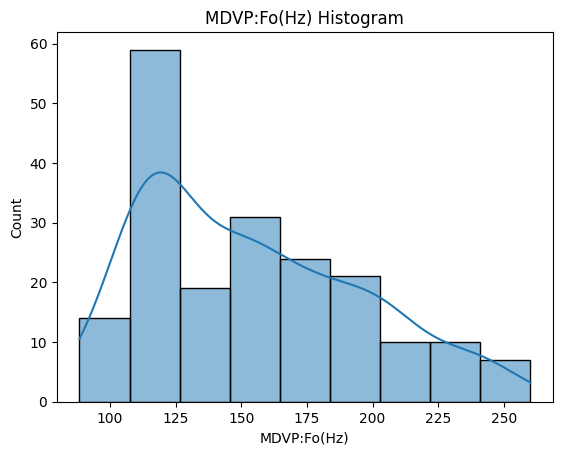

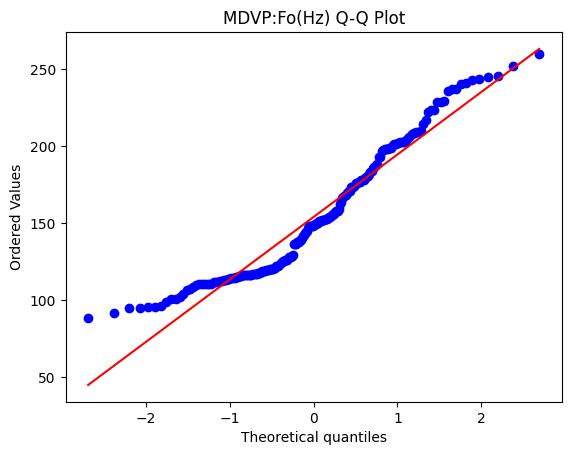


Column: MDVP:Fhi(Hz)
Skewness: 2.5225490936388146
The distribution is highly right-skewed
Kurtosis: 7.402457667216268
The distribution is highly leptokurtic (peaked)
Shapiro-Wilk test p-value: 9.295729992417817e-18
The data is not normally distributed


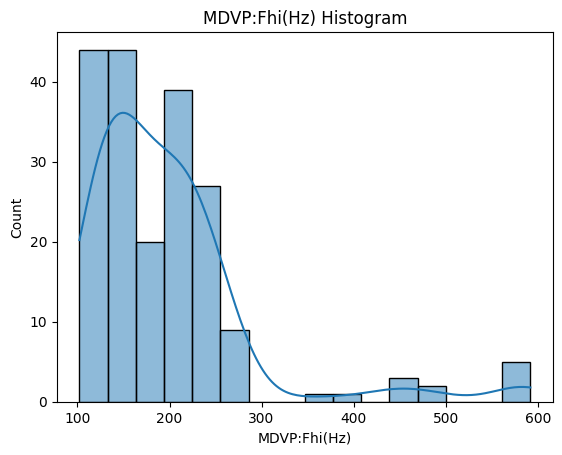

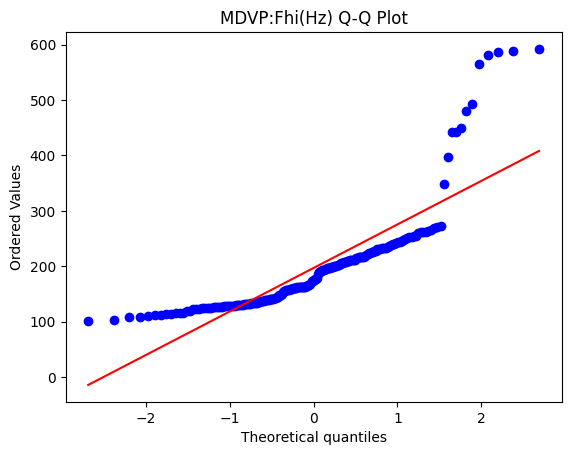


Column: MDVP:Flo(Hz)
Skewness: 1.2079661332354688
The distribution is highly right-skewed
Kurtosis: 0.6073373578620544
The distribution is approximately mesokurtic (normal)
Shapiro-Wilk test p-value: 2.2742883964976812e-12
The data is not normally distributed


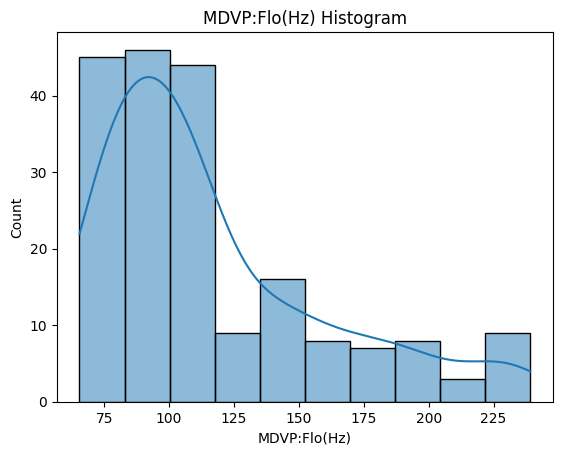

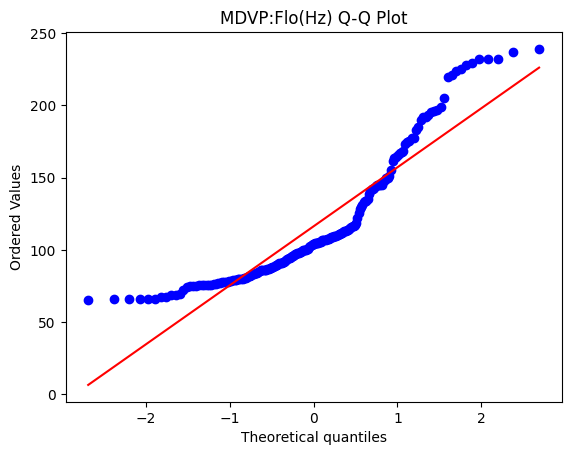


Column: MDVP:Jitter(%)
Skewness: 3.061164957386332
The distribution is highly right-skewed
Kurtosis: 11.694048122714815
The distribution is highly leptokurtic (peaked)
Shapiro-Wilk test p-value: 6.427849934148239e-19
The data is not normally distributed


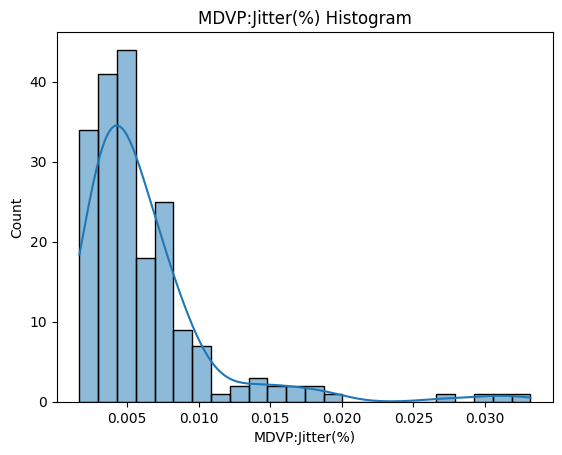

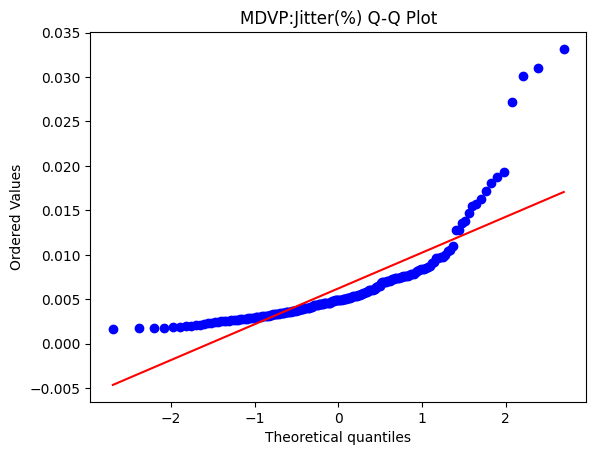


Column: MDVP:Jitter(Abs)
Skewness: 2.6286502455329948
The distribution is highly right-skewed
Kurtosis: 10.5617304738652
The distribution is highly leptokurtic (peaked)
Shapiro-Wilk test p-value: 2.5662967484547364e-16
The data is not normally distributed


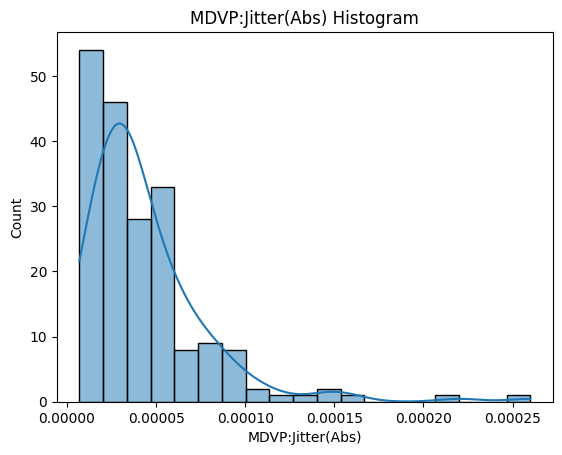

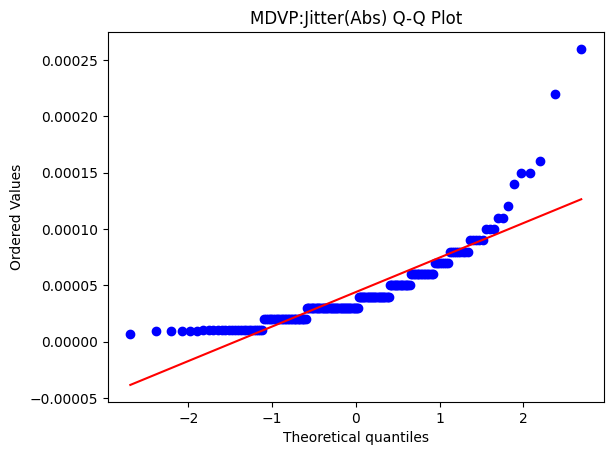


Column: MDVP:RAP
Skewness: 3.334801409433699
The distribution is highly right-skewed
Kurtosis: 13.821336218407716
The distribution is highly leptokurtic (peaked)
Shapiro-Wilk test p-value: 6.996990908380496e-20
The data is not normally distributed


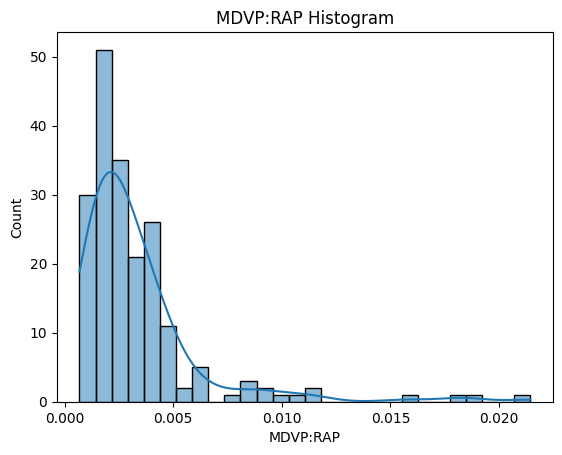

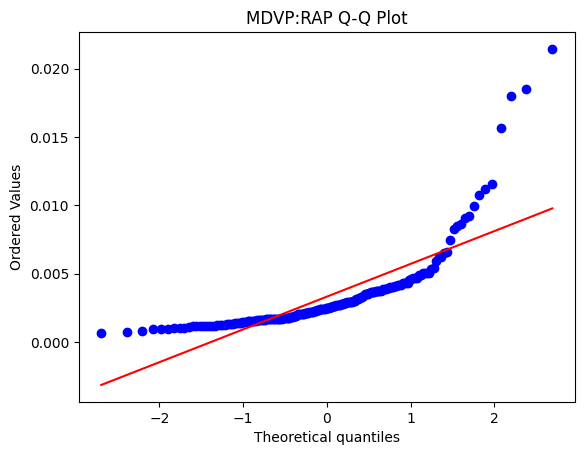


Column: MDVP:PPQ
Skewness: 3.050196424967615
The distribution is highly right-skewed
Kurtosis: 11.628737063088646
The distribution is highly leptokurtic (peaked)
Shapiro-Wilk test p-value: 5.374223459029992e-19
The data is not normally distributed


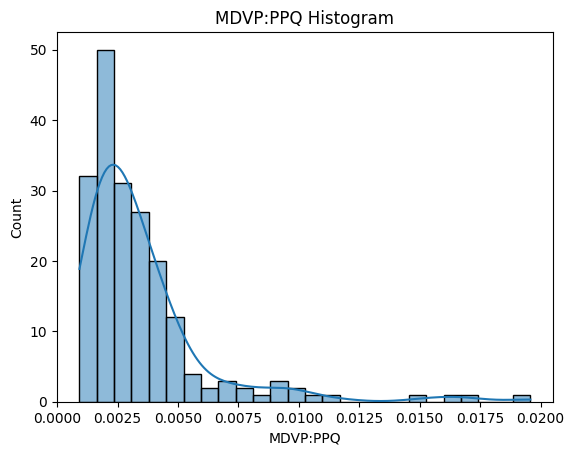

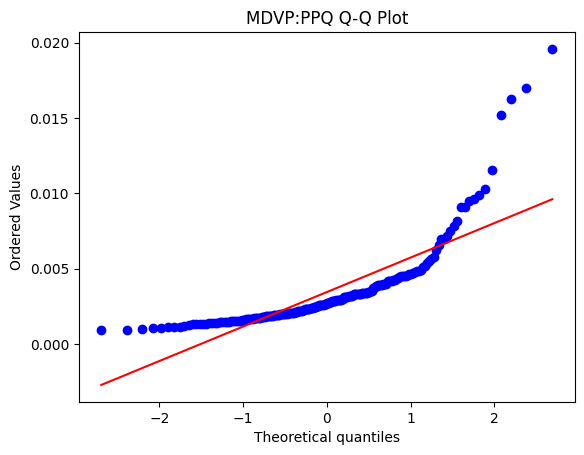


Column: Jitter:DDP
Skewness: 3.3361409999741496
The distribution is highly right-skewed
Kurtosis: 13.832021286242266
The distribution is highly leptokurtic (peaked)
Shapiro-Wilk test p-value: 6.938189352820486e-20
The data is not normally distributed


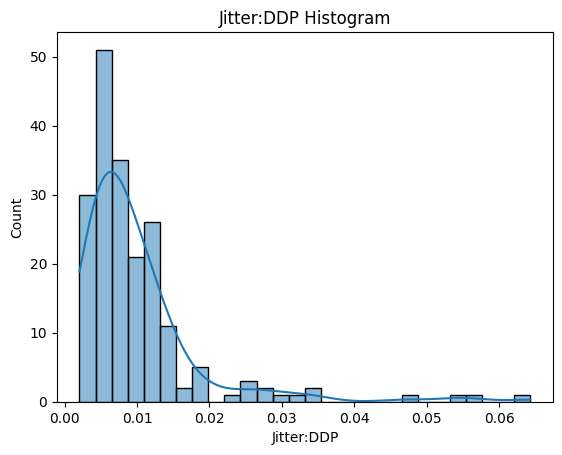

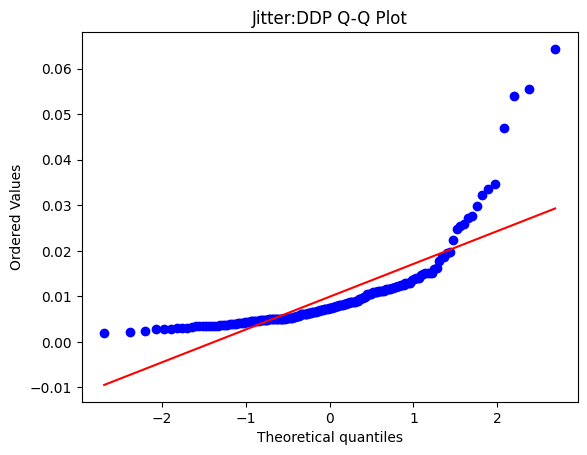


Column: MDVP:Shimmer
Skewness: 1.6536338401467416
The distribution is highly right-skewed
Kurtosis: 3.1252562951017673
The distribution is highly leptokurtic (peaked)
Shapiro-Wilk test p-value: 1.4874616837724786e-13
The data is not normally distributed


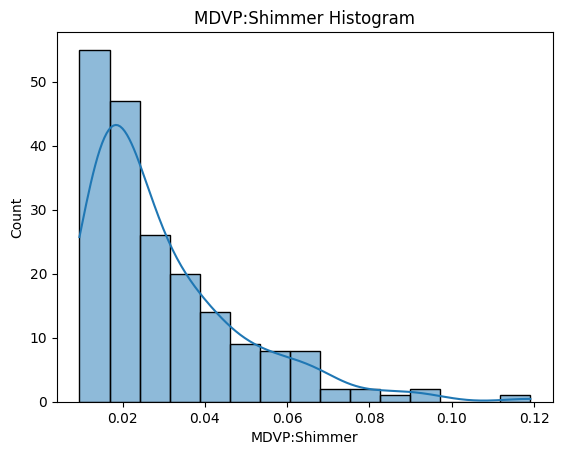

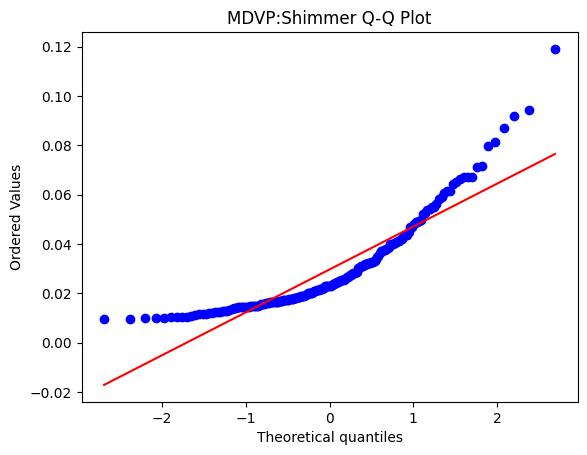


Column: MDVP:Shimmer(dB)
Skewness: 1.983975744958398
The distribution is highly right-skewed
Kurtosis: 4.967028761983708
The distribution is highly leptokurtic (peaked)
Shapiro-Wilk test p-value: 5.64582230047476e-15
The data is not normally distributed


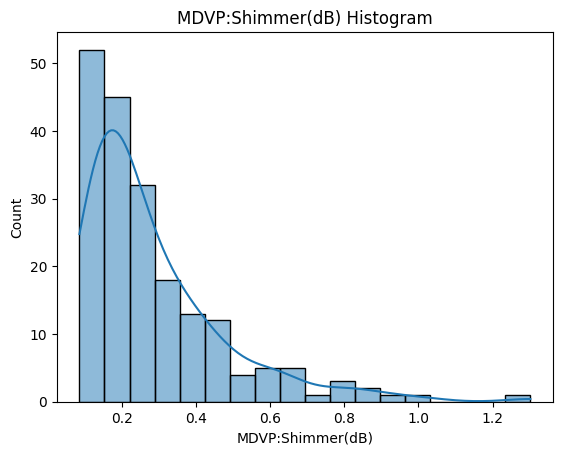

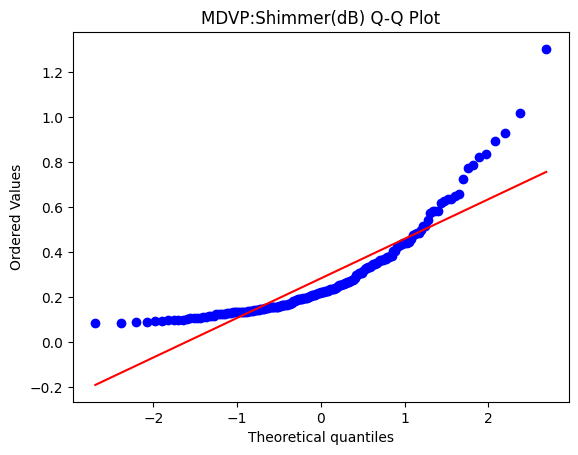


Column: Shimmer:APQ3
Skewness: 1.5683920271611078
The distribution is highly right-skewed
Kurtosis: 2.620290846751314
The distribution is highly leptokurtic (peaked)
Shapiro-Wilk test p-value: 4.604056936044487e-13
The data is not normally distributed


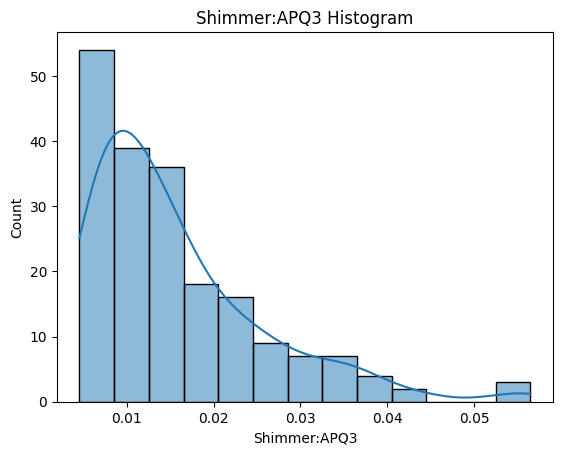

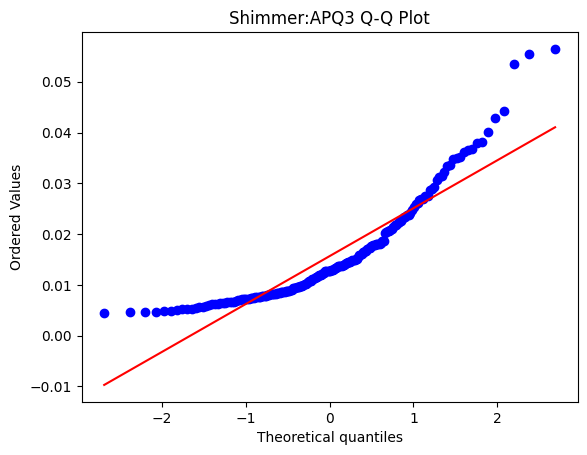


Column: Shimmer:APQ5
Skewness: 1.7848312643056599
The distribution is highly right-skewed
Kurtosis: 3.744969305059212
The distribution is highly leptokurtic (peaked)
Shapiro-Wilk test p-value: 1.3113382077531866e-14
The data is not normally distributed


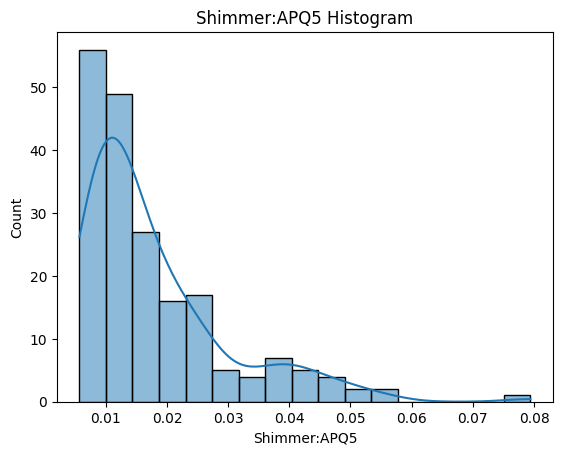

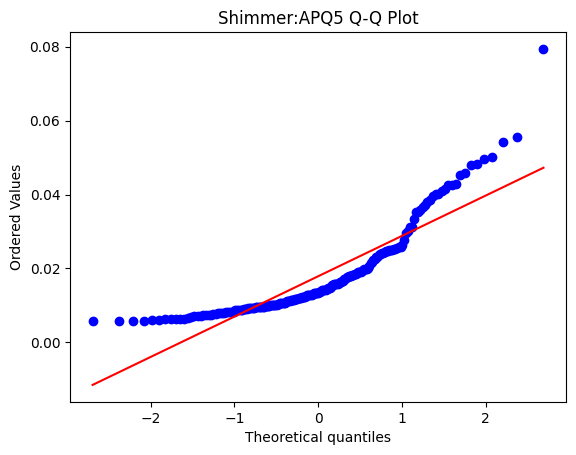


Column: MDVP:APQ
Skewness: 2.5978644961905406
The distribution is highly right-skewed
Kurtosis: 10.848485539030966
The distribution is highly leptokurtic (peaked)
Shapiro-Wilk test p-value: 1.8690227996952426e-16
The data is not normally distributed


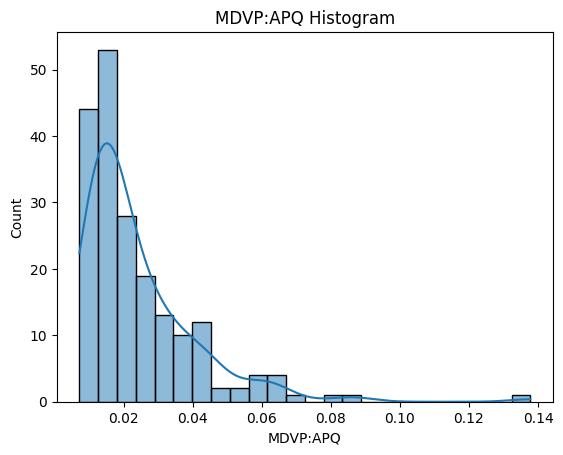

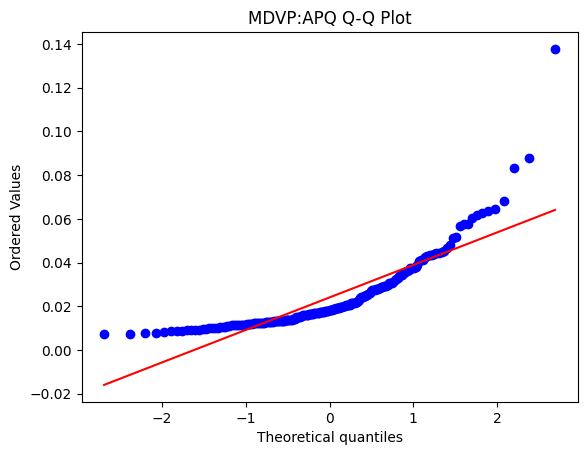


Column: Shimmer:DDA
Skewness: 1.5684333201651852
The distribution is highly right-skewed
Kurtosis: 2.6207875757870287
The distribution is highly leptokurtic (peaked)
Shapiro-Wilk test p-value: 4.607557282758357e-13
The data is not normally distributed


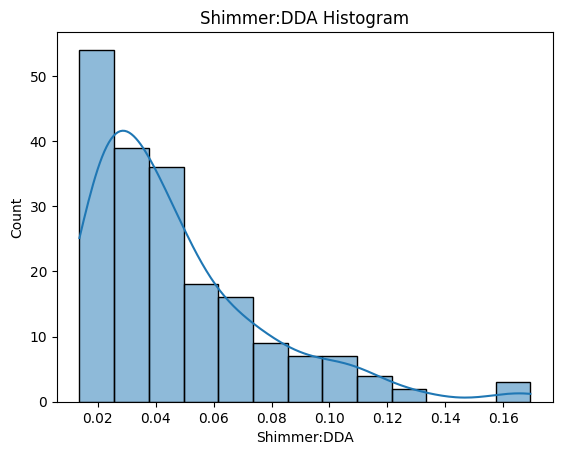

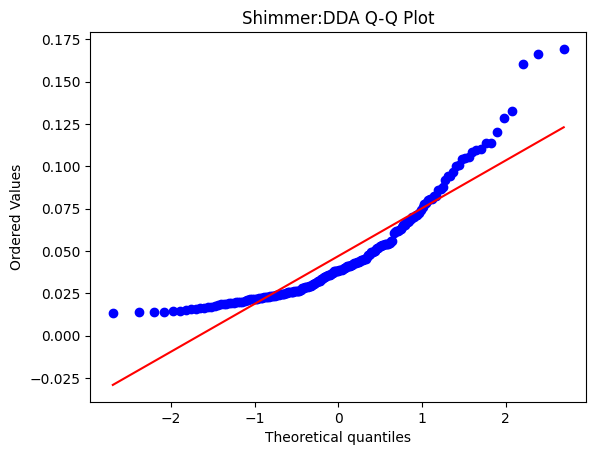


Column: NHR
Skewness: 4.188172511855344
The distribution is highly right-skewed
Kurtosis: 21.404422491186665
The distribution is highly leptokurtic (peaked)
Shapiro-Wilk test p-value: 9.394444177169885e-23
The data is not normally distributed


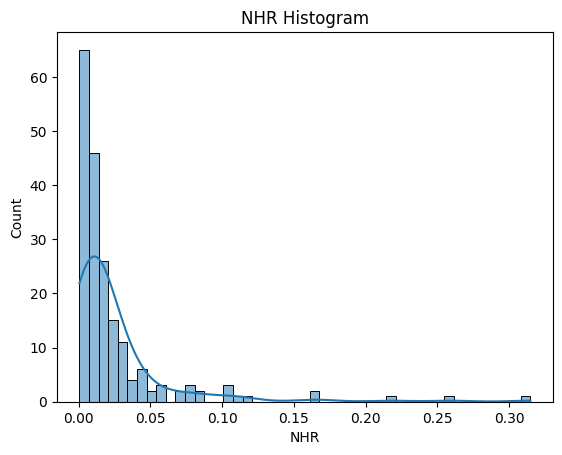

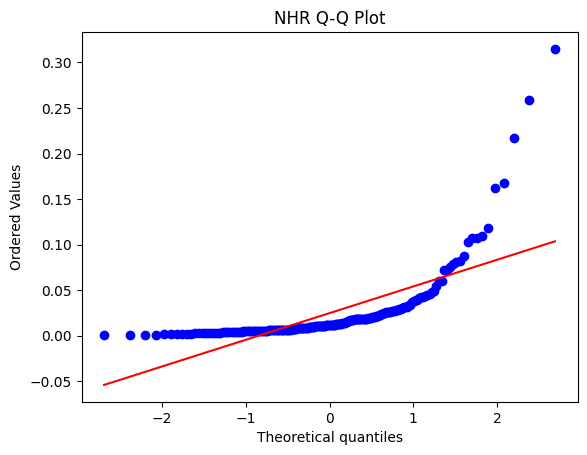


Column: HNR
Skewness: -0.510352725042725
The distribution is moderately left-skewed
Kurtosis: 0.5697407921207636
The distribution is approximately mesokurtic (normal)
Shapiro-Wilk test p-value: 0.0006426100735552609
The data is not normally distributed


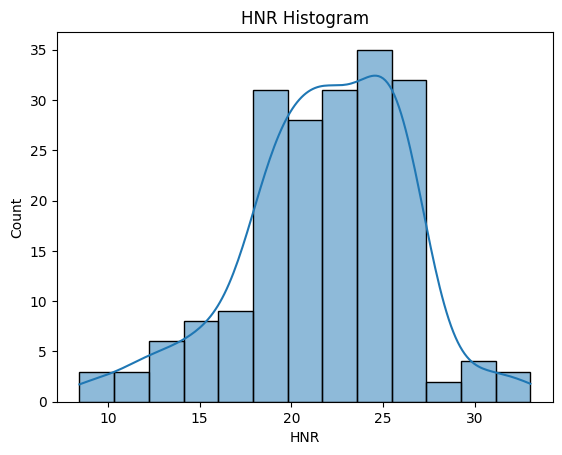

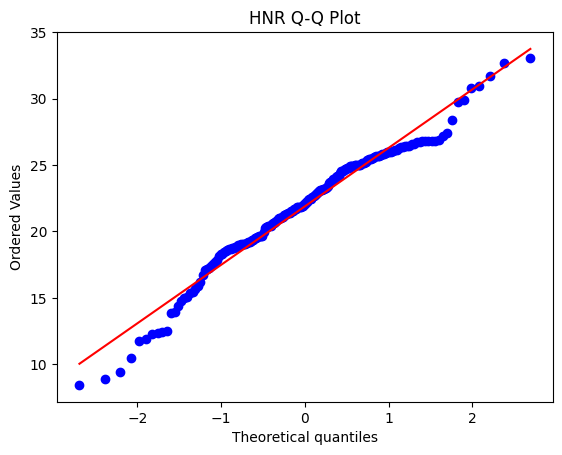


Column: status
Skewness: -1.1785714285714286
The distribution is highly left-skewed
Kurtosis: -0.6109693877551026
The distribution is approximately mesokurtic (normal)
Shapiro-Wilk test p-value: 1.6425577202622868e-22
The data is not normally distributed


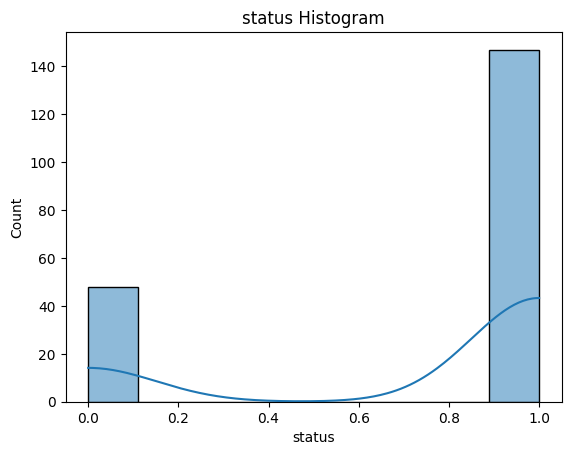

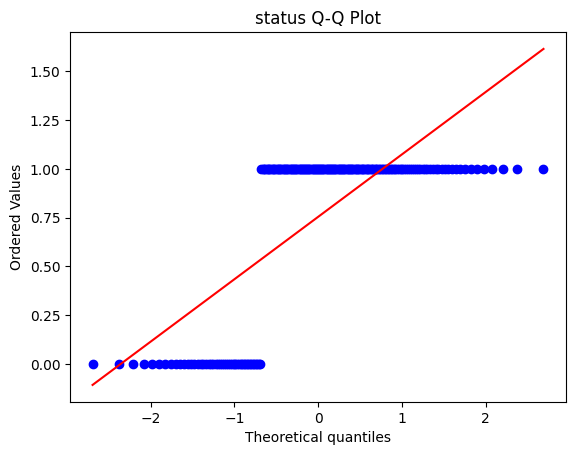


Column: RPDE
Skewness: -0.14229695276961832
The distribution is approximately symmetric
Kurtosis: -0.9289268859608506
The distribution is approximately mesokurtic (normal)
Shapiro-Wilk test p-value: 0.0005725460941903293
The data is not normally distributed


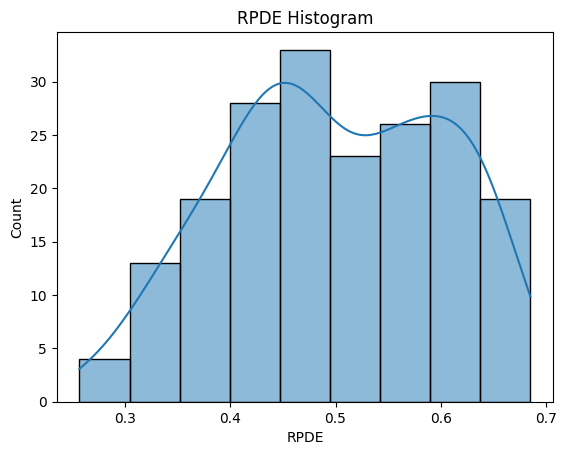

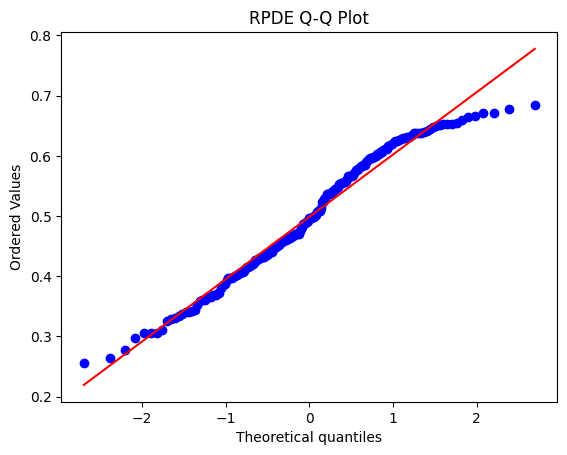


Column: DFA
Skewness: -0.032957623130060634
The distribution is approximately symmetric
Kurtosis: -0.6992963109096335
The distribution is approximately mesokurtic (normal)
Shapiro-Wilk test p-value: 0.014322146773338318
The data is not normally distributed


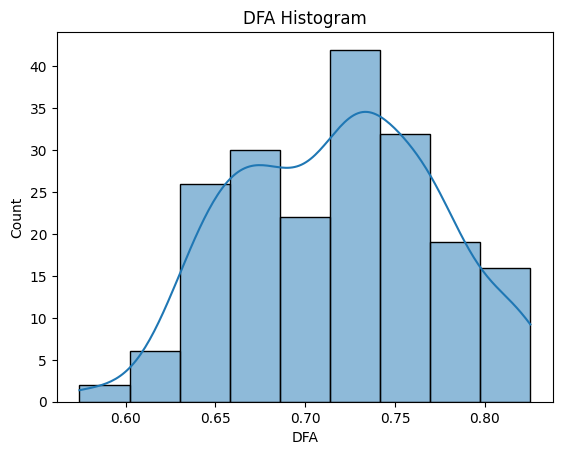

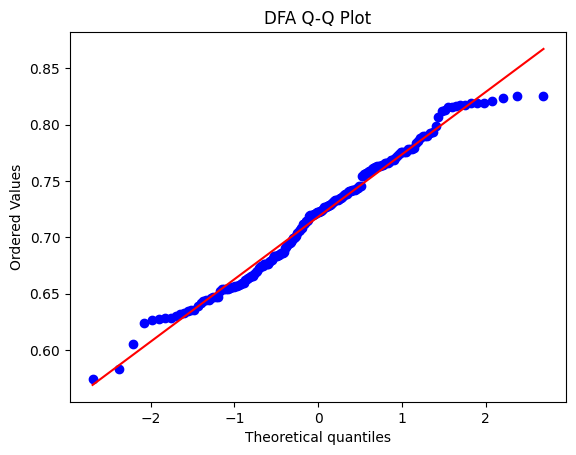


Column: spread1
Skewness: 0.4288076579039929
The distribution is approximately symmetric
Kurtosis: -0.07953347553766532
The distribution is approximately mesokurtic (normal)
Shapiro-Wilk test p-value: 0.025684863328933716
The data is not normally distributed


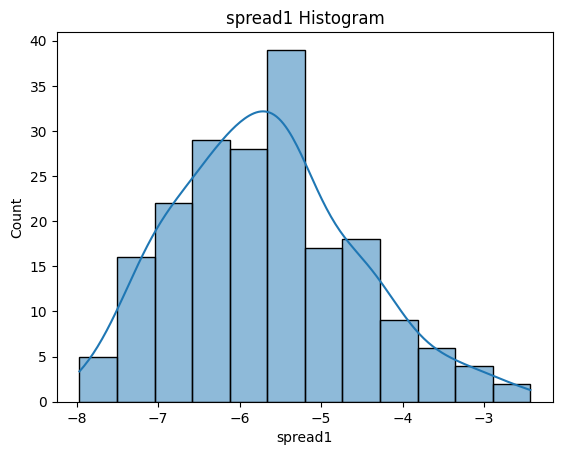

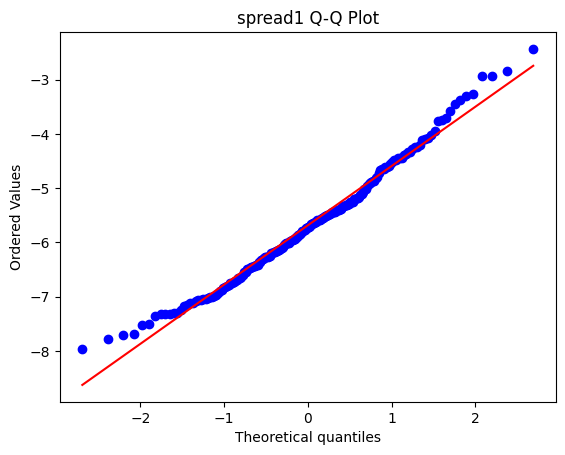


Column: spread2
Skewness: 0.14331709926151373
The distribution is approximately symmetric
Kurtosis: -0.11152157409176144
The distribution is approximately mesokurtic (normal)
Shapiro-Wilk test p-value: 0.6544738411903381
The data is normally distributed


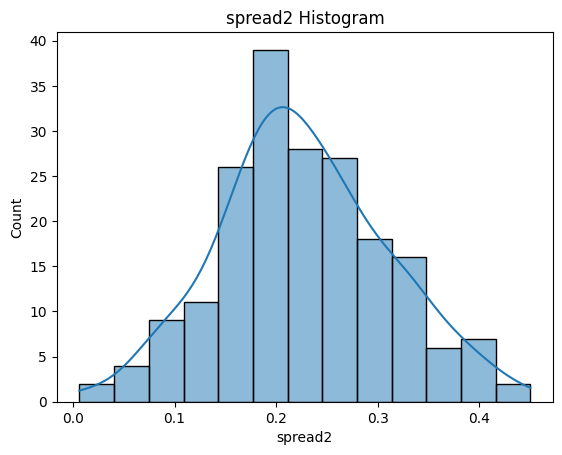

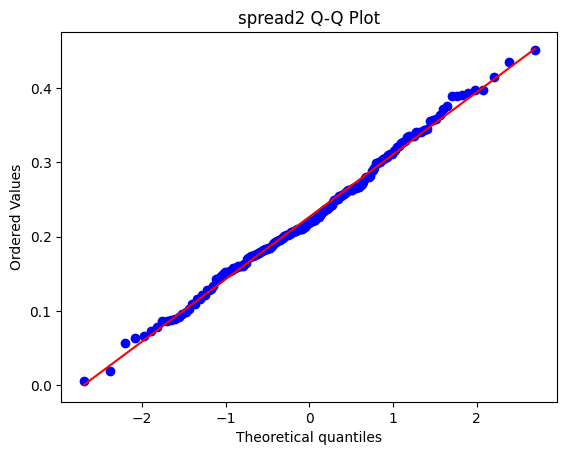


Column: D2
Skewness: 0.42706614648747077
The distribution is approximately symmetric
Kurtosis: 0.18411268114290058
The distribution is approximately mesokurtic (normal)
Shapiro-Wilk test p-value: 0.042679544538259506
The data is not normally distributed


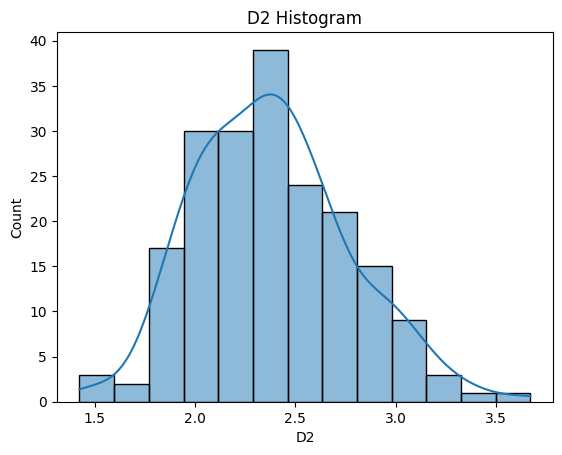

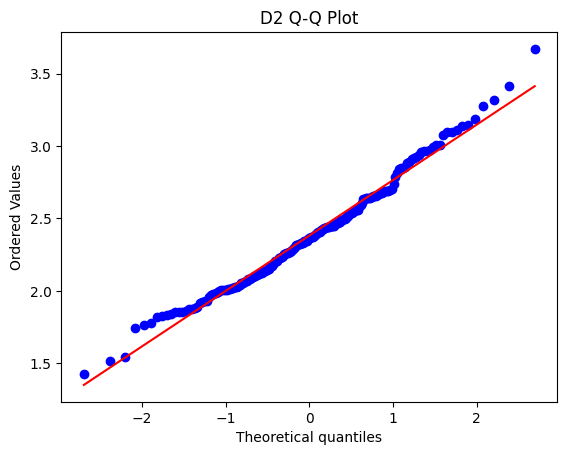


Column: PPE
Skewness: 0.7913433696864662
The distribution is moderately right-skewed
Kurtosis: 0.4842725596097872
The distribution is approximately mesokurtic (normal)
Shapiro-Wilk test p-value: 1.0468026630405802e-05
The data is not normally distributed


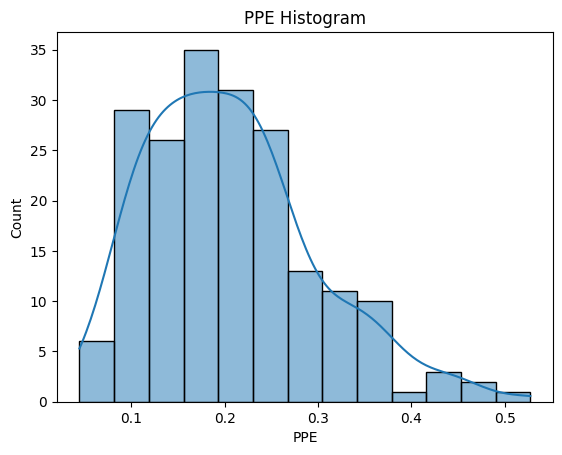

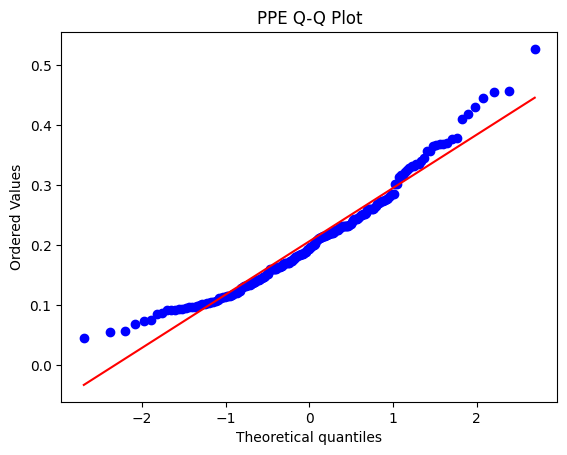

In [ ]:

# Load your dataset as a Pandas DataFrame
df_num = df[['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE']]

# Loop over each column in the DataFrame
for col in df_num.columns:
    # Calculate skewness and kurtosis
    skewness = skew(df_num[col])
    kurt = kurtosis(df_num[col])

    # Print the results
    print("Column:", col)
    print("Skewness:", skewness)
    if skewness < -1:
        print("The distribution is highly left-skewed")
    elif -1 <= skewness < -0.5:
        print("The distribution is moderately left-skewed")
    elif -0.5 <= skewness < 0.5:
        print("The distribution is approximately symmetric")
    elif 0.5 <= skewness < 1:
        print("The distribution is moderately right-skewed")
    else:
        print("The distribution is highly right-skewed")

    print("Kurtosis:", kurt)
    if kurt < -2:
        print("The distribution is highly platykurtic (flat)")
    elif -2 <= kurt < -1:
        print("The distribution is moderately platykurtic (flat)")
    elif -1 <= kurt < 1:
        print("The distribution is approximately mesokurtic (normal)")
    elif 1 <= kurt < 2:
        print("The distribution is moderately leptokurtic (peaked)")
    else:
        print("The distribution is highly leptokurtic (peaked)")

    # Perform Shapiro-Wilk test for normality
    stat, p = shapiro(df[col])
    print("Shapiro-Wilk test p-value:", p)
    if p > 0.05:
        print("The data is normally distributed")
    else:
        print("The data is not normally distributed")
    
    # Create histogram
    sns.histplot(df[col], kde=True)
    plt.title(col + ' Histogram')
    plt.show()
    
    # Create Q-Q plot
    fig, ax = plt.subplots()
    stats.probplot(df[col], plot=ax)
    ax.set_title(col + ' Q-Q Plot')
    plt.show()
    
    print()


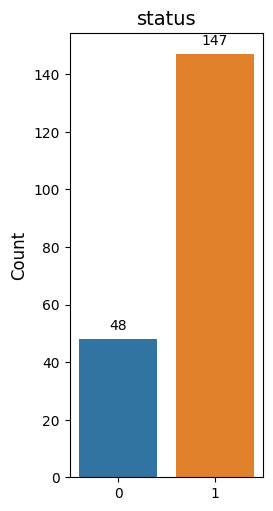

In [ ]:
#Count Plot

vars_list = ['status']


# Set the figure size and layout
plt.figure(figsize=(20, 30))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop through the variables and create countplots
for i, var in enumerate(vars_list):
    ax = plt.subplot(4,6, i+1) # Set the subplot position
    sns.countplot(x=var, data=df, ax=ax) # Create the countplot
    plt.title(var, fontsize=14) # Set the title font size
    plt.xlabel("") # Remove the x-axis label
    plt.ylabel("Count", fontsize=12) # Set the y-axis label font size
    # Add count values to each bar
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=10)

plt.show() # Show the plots


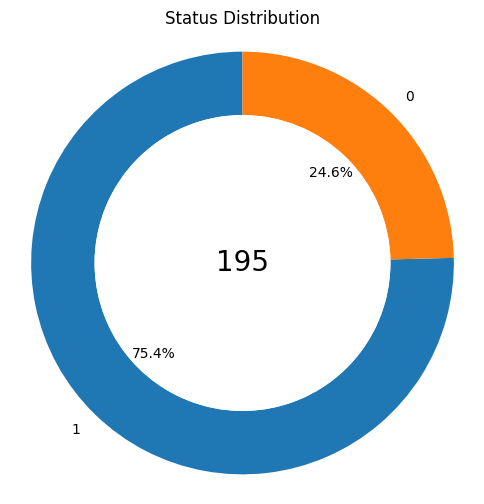

In [ ]:

# Count the data points for each category
count_data = df['status'].value_counts()

# Create a donut chart
plt.figure(figsize=(6, 6))
plt.pie(count_data, labels=count_data.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.3))

# Draw a white circle at the center to create the donut effect
center_circle = plt.Circle((0, 0), 0.7, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Add the count in the center of the donut
plt.text(0, 0, sum(count_data), ha='center', va='center', fontsize=20)

plt.axis('equal')  # Equal aspect ratio ensures that the chart appears as a circle
plt.title('Status Distribution')  # Set the chart title

plt.show()  # Show the donut chart


In [ ]:
from scipy.stats import ttest_ind
import pandas as pd


# Specify the binary target variable
target_var = 'status'

# Specify the list of continuous independent variables
independent_vars = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE']

# Loop through the independent variables and perform the t-test
for independent_var in independent_vars:
    group_1 = df[df[target_var] == 0][independent_var]
    group_2 = df[df[target_var] == 1][independent_var]
    t_stat, p_value = ttest_ind(group_1, group_2)
    print(f"T-Test for {independent_var}: T-statistic = {t_stat:.3f}, P-value = {p_value:.3f}, Significance = {'Yes' if p_value < 0.05 else 'No'}")


T-Test for MDVP:Fo(Hz): T-statistic = 5.769, P-value = 0.000, Significance = Yes
T-Test for MDVP:Fhi(Hz): T-statistic = 2.341, P-value = 0.020, Significance = Yes
T-Test for MDVP:Flo(Hz): T-statistic = 5.711, P-value = 0.000, Significance = Yes
T-Test for MDVP:Jitter(%): T-statistic = -4.024, P-value = 0.000, Significance = Yes
T-Test for MDVP:Jitter(Abs): T-statistic = -5.000, P-value = 0.000, Significance = Yes
T-Test for MDVP:RAP: T-statistic = -3.844, P-value = 0.000, Significance = Yes
T-Test for MDVP:PPQ: T-statistic = -4.189, P-value = 0.000, Significance = Yes
T-Test for Jitter:DDP: T-statistic = -3.844, P-value = 0.000, Significance = Yes
T-Test for MDVP:Shimmer: T-statistic = -5.488, P-value = 0.000, Significance = Yes
T-Test for MDVP:Shimmer(dB): T-statistic = -5.202, P-value = 0.000, Significance = Yes
T-Test for Shimmer:APQ3: T-statistic = -5.150, P-value = 0.000, Significance = Yes
T-Test for Shimmer:APQ5: T-statistic = -5.210, P-value = 0.000, Significance = Yes
T-Test f

In [ ]:
from scipy.stats import t

# specify the significance level (alpha) and degrees of freedom (df)
alpha = 0.05
df1 = len(group_1) + len(group_2) - 2

# calculate the critical t-value for a two-tailed test
critical_t = t.ppf(1 - alpha / 2, df1)

print(f"Critical t-value for alpha={alpha:.2f} and df_rows={df1}: {critical_t:.3f}")


Critical t-value for alpha=0.05 and df_rows=193: 1.972


In [ ]:
df.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr



variables = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR',  'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE', 'status']


selected_data = df[variables]


corr_matrix = selected_data.corr()


p_values = np.zeros_like(corr_matrix)
for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        corr, p_val = pearsonr(selected_data[variables[i]], selected_data[variables[j]])
        p_values[i, j] = p_val

p_values[p_values == 0] = np.nan


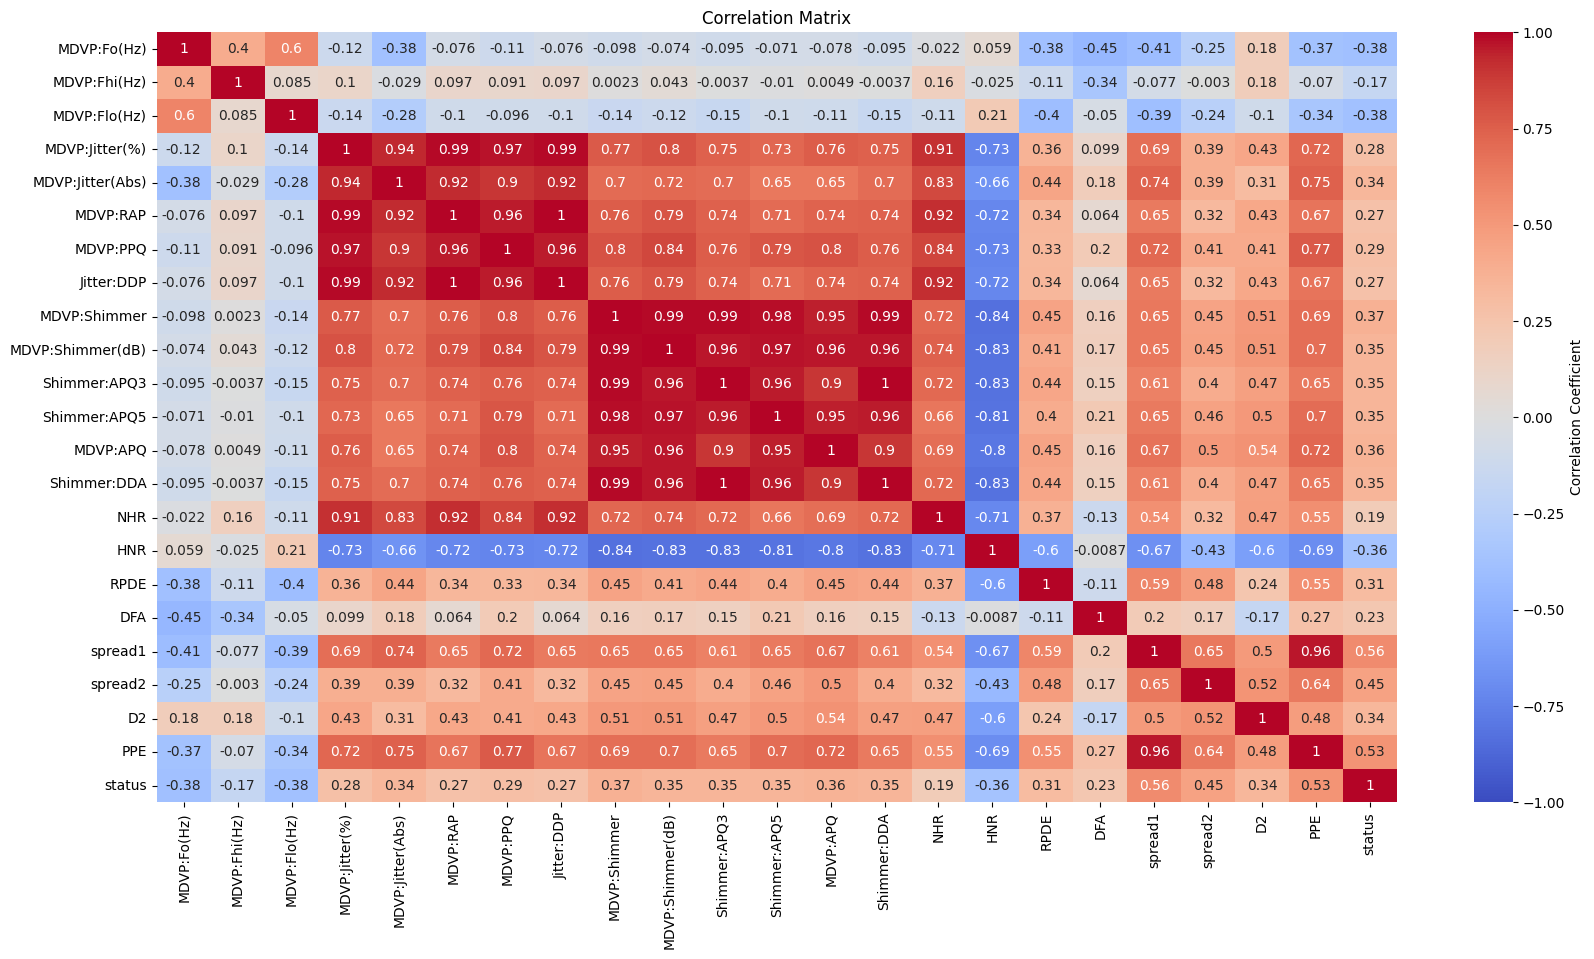

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix')
plt.show()


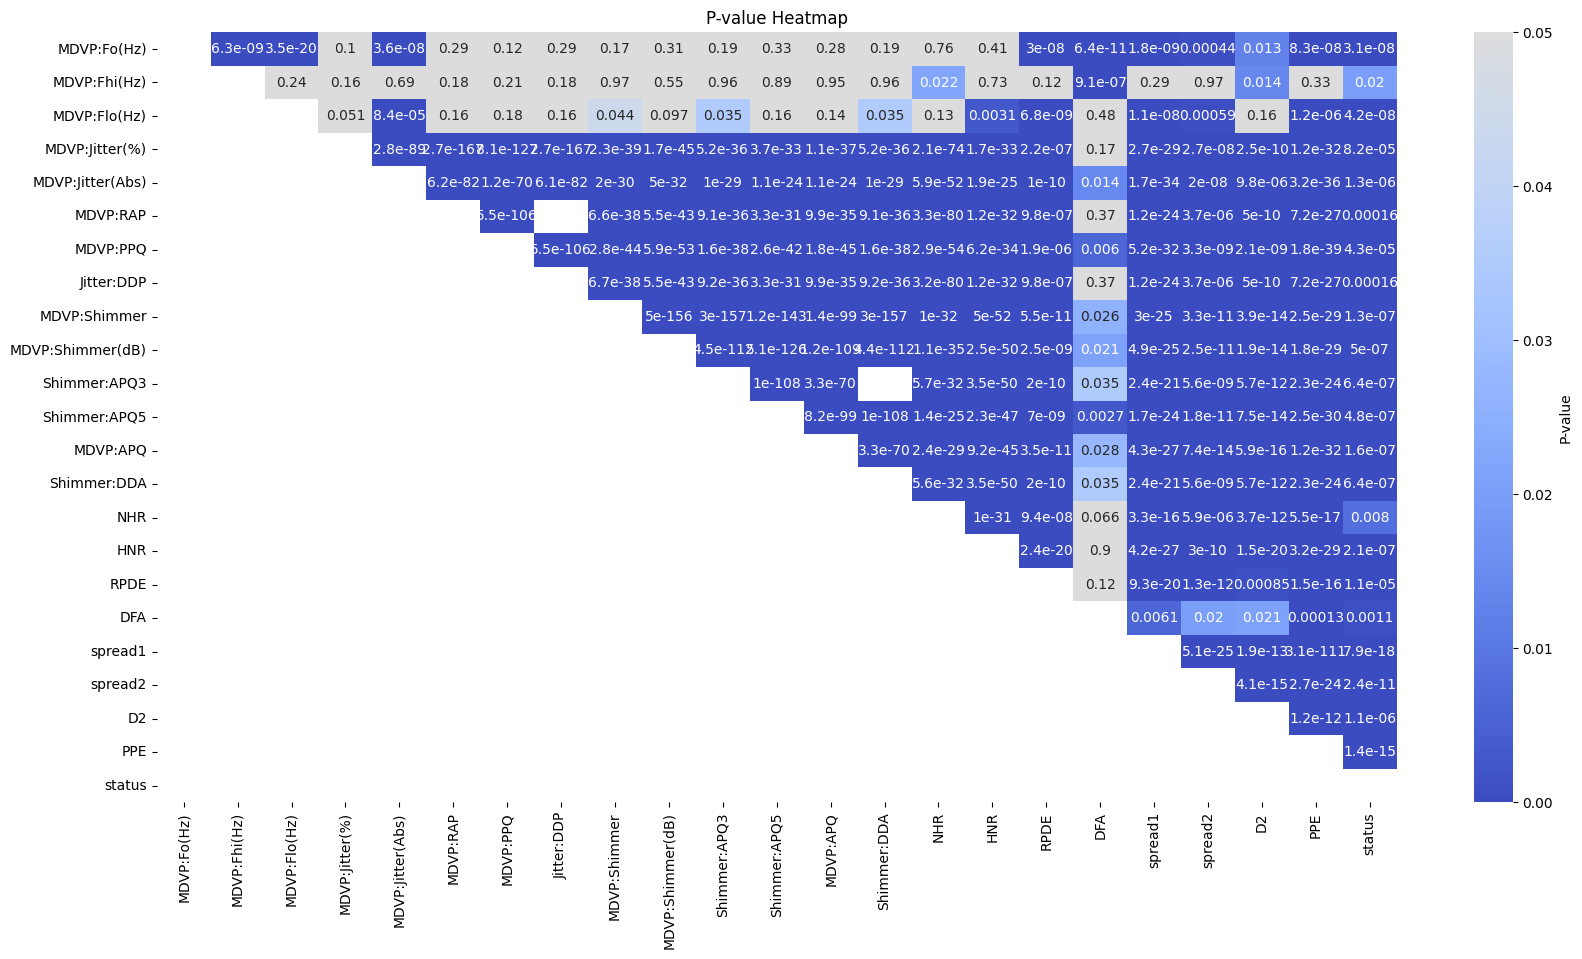

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(p_values, annot=True, cmap='coolwarm', vmin=0, vmax=0.05, center=0.05,
            xticklabels=variables, yticklabels=variables,
            cbar_kws={'label': 'P-value'})
plt.title('P-value Heatmap')
plt.show()

# Applying PCA to Identify Key Variables in Frequency Data

In [ ]:
df1 = df[['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)']]

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


X = df1
Y = df[['status']]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

pca = PCA().fit(X)

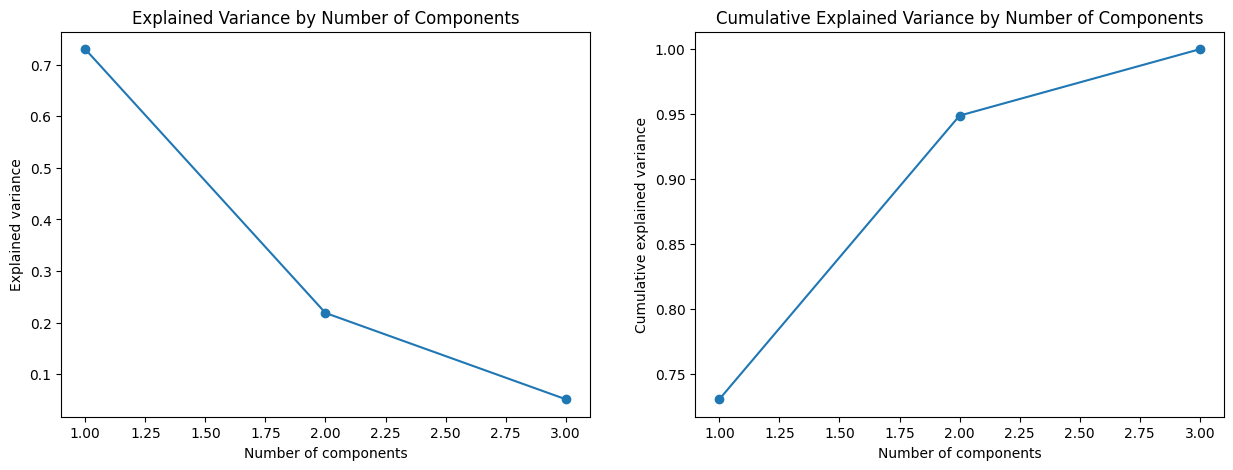

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# plot explained variance
ax[0].plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_ratio_, marker='o')
ax[0].set_xlabel('Number of components')
ax[0].set_ylabel('Explained variance')
ax[0].set_title('Explained Variance by Number of Components')

# plot cumulative explained variance
ax[1].plot(range(1, len(pca.explained_variance_)+1), np.cumsum(pca.explained_variance_ratio_), marker='o')
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Cumulative explained variance')
ax[1].set_title('Cumulative Explained Variance by Number of Components')

plt.show()


In [ ]:
# Select the number of components that explain at least 80-90% of the variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_explained_variance >= 0.8) + 1
print(f'Number of components to explain 80% of variance: {n_components}')


Number of components to explain 80% of variance: 2


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA


# Get the loadings for each variable
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

print(loadings)


                   PC1       PC2       PC3
MDVP:Fo(Hz)   0.222362  0.590028 -0.776158
MDVP:Fhi(Hz)  0.971440 -0.201706  0.124974
MDVP:Flo(Hz)  0.082818  0.781781  0.618029


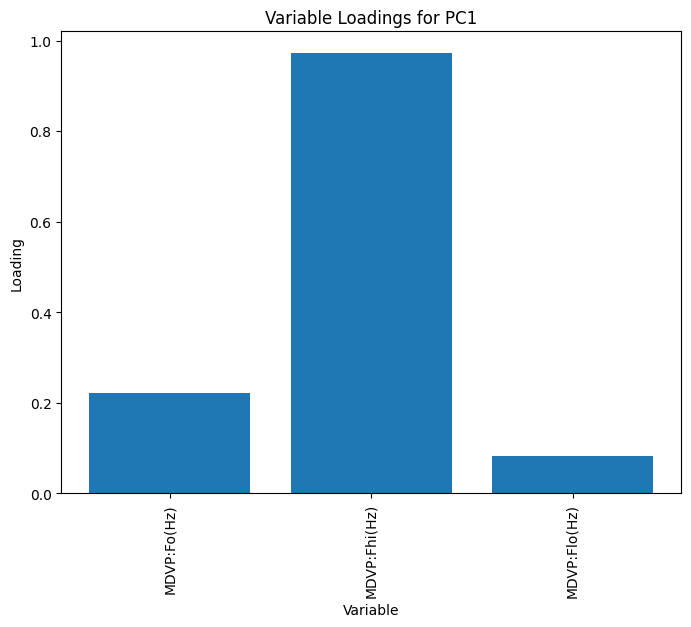

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Get the loadings for each variable
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Get the loadings for the first principal component
loadings_pc1 = loadings['PC1']

# Plot the variable loadings for the first principal component
plt.figure(figsize=(8, 6))
plt.bar(x=loadings_pc1.index, height=loadings_pc1.values)
plt.xticks(rotation=90)
plt.title('Variable Loadings for PC1')
plt.xlabel('Variable')
plt.ylabel('Loading')
plt.show()


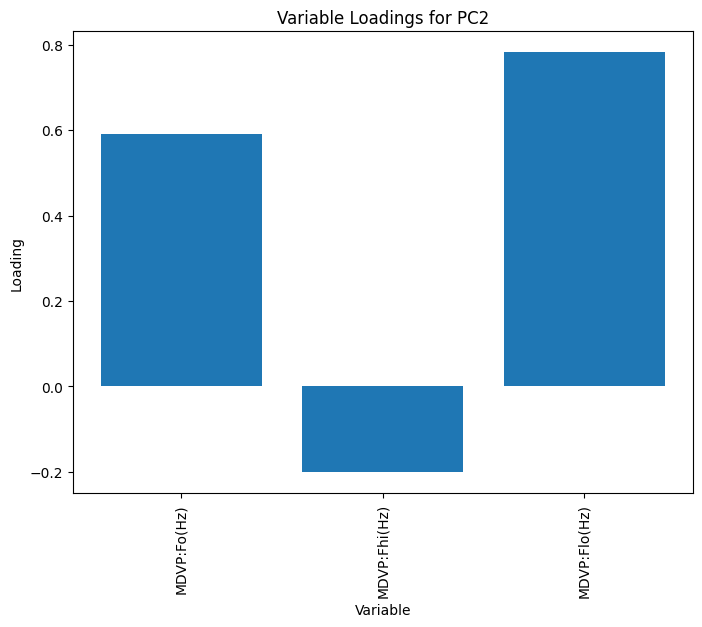

In [ ]:
loadings_pc1 = loadings['PC2']
# Plot the variable loadings for the first principal component
plt.figure(figsize=(8, 6))
plt.bar(x=loadings_pc1.index, height=loadings_pc1.values)
plt.xticks(rotation=90)
plt.title('Variable Loadings for PC2')
plt.xlabel('Variable')
plt.ylabel('Loading')
plt.show()


**Selection of MDVP:Fhi(Hz) as the Key Variable for Final Modeling from the MDVP Frequency Variables**

# Applying PCA to Identify Key Variables in Jitter Data

In [ ]:
df.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [ ]:
df2 = df[['MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP']]

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


X = df2
Y = df[['status']]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

pca = PCA().fit(X)

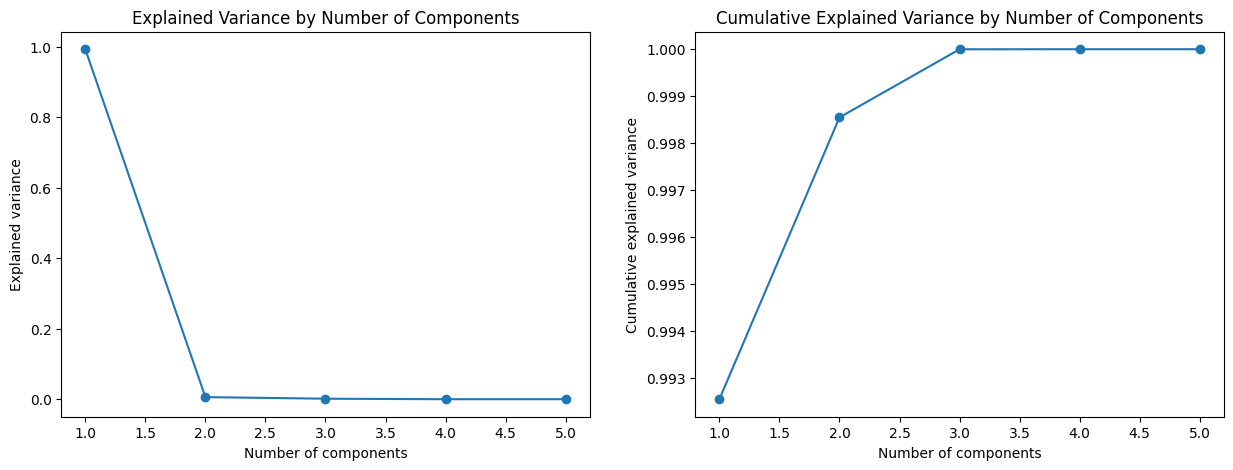

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# plot explained variance
ax[0].plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_ratio_, marker='o')
ax[0].set_xlabel('Number of components')
ax[0].set_ylabel('Explained variance')
ax[0].set_title('Explained Variance by Number of Components')

# plot cumulative explained variance
ax[1].plot(range(1, len(pca.explained_variance_)+1), np.cumsum(pca.explained_variance_ratio_), marker='o')
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Cumulative explained variance')
ax[1].set_title('Cumulative Explained Variance by Number of Components')

plt.show()


In [ ]:
# Select the number of components that explain at least 80-90% of the variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_explained_variance >= 0.8) + 1
print(f'Number of components to explain 80% of variance: {n_components}')


Number of components to explain 80% of variance: 1


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA


# Get the loadings for each variable
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

print(loadings)


                       PC1       PC2       PC3       PC4       PC5
MDVP:Jitter(%)    0.443446 -0.432066  0.785207  0.011192 -0.000031
MDVP:Jitter(Abs)  0.002969 -0.002199  0.011366 -0.999928  0.001356
MDVP:RAP          0.272616  0.140851 -0.076432  0.000917  0.948683
MDVP:PPQ          0.245253 -0.784204 -0.569963 -0.004026  0.000038
Jitter:DDP        0.817850  0.422492 -0.229392 -0.001537 -0.316226


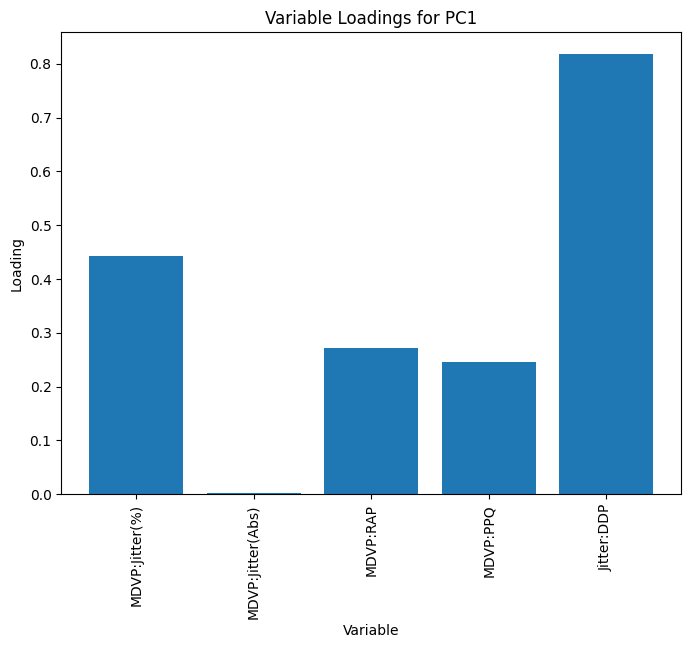

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Get the loadings for each variable
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Get the loadings for the first principal component
loadings_pc1 = loadings['PC1']

# Plot the variable loadings for the first principal component
plt.figure(figsize=(8, 6))
plt.bar(x=loadings_pc1.index, height=loadings_pc1.values)
plt.xticks(rotation=90)
plt.title('Variable Loadings for PC1')
plt.xlabel('Variable')
plt.ylabel('Loading')
plt.show()


**Selection of Jitter:DDP as the Key Variable for Final Modeling from the MDVP Jitter Variables**

# Applying PCA to Identify Key Variables in spread1, spread2, D2, PPE

In [ ]:
df.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [ ]:
df3 = df[['spread1', 'spread2', 'D2', 'PPE']]

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


X = df3
Y = df[['status']]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

pca = PCA().fit(X)

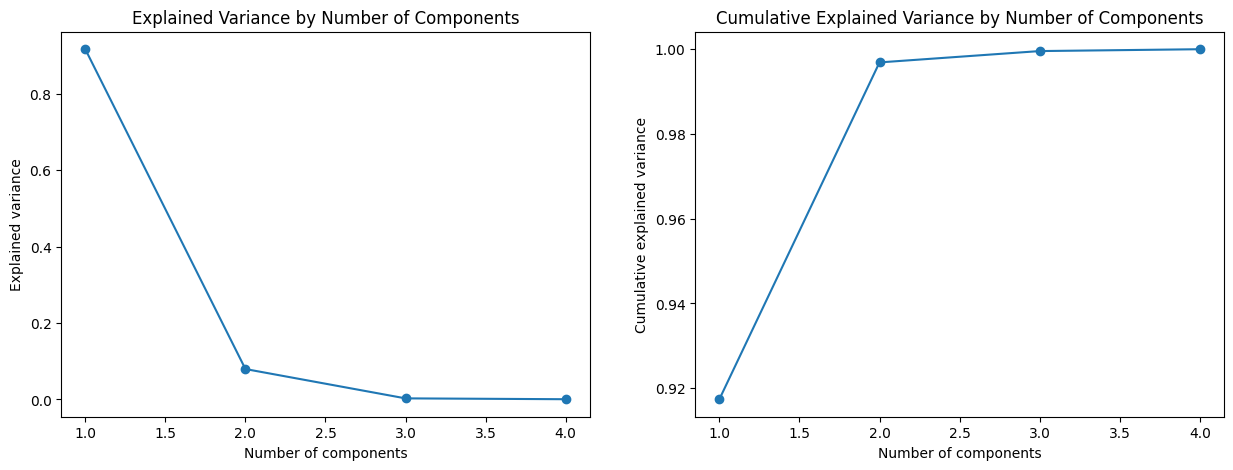

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# plot explained variance
ax[0].plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_ratio_, marker='o')
ax[0].set_xlabel('Number of components')
ax[0].set_ylabel('Explained variance')
ax[0].set_title('Explained Variance by Number of Components')

# plot cumulative explained variance
ax[1].plot(range(1, len(pca.explained_variance_)+1), np.cumsum(pca.explained_variance_ratio_), marker='o')
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Cumulative explained variance')
ax[1].set_title('Cumulative Explained Variance by Number of Components')

plt.show()


In [ ]:
# Select the number of components that explain at least 80-90% of the variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_explained_variance >= 0.8) + 1
print(f'Number of components to explain 80% of variance: {n_components}')


Number of components to explain 80% of variance: 1


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA


# Get the loadings for each variable
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

print(loadings)


              PC1       PC2       PC3       PC4
spread1  0.977996 -0.188985  0.042334  0.077564
spread2  0.049946  0.050933 -0.996715  0.038343
D2       0.186990  0.980561  0.059438 -0.001035
PPE      0.077871 -0.013772 -0.035127 -0.996249


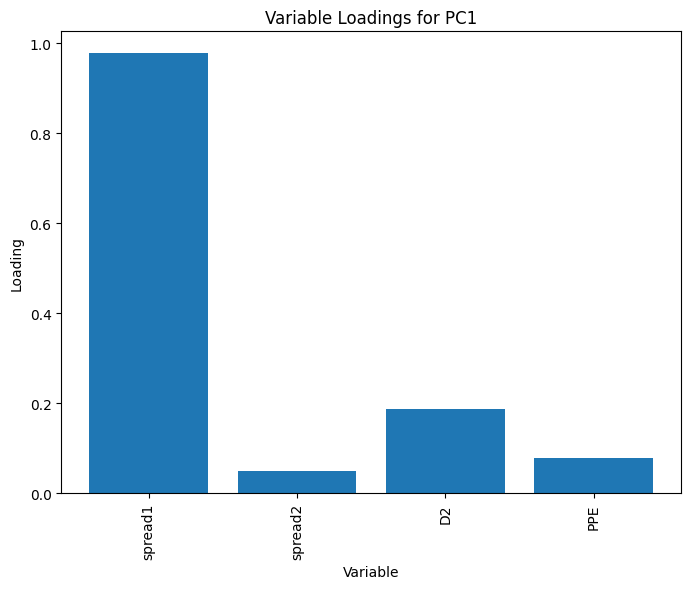

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Get the loadings for each variable
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Get the loadings for the first principal component
loadings_pc1 = loadings['PC1']

# Plot the variable loadings for the first principal component
plt.figure(figsize=(8, 6))
plt.bar(x=loadings_pc1.index, height=loadings_pc1.values)
plt.xticks(rotation=90)
plt.title('Variable Loadings for PC1')
plt.xlabel('Variable')
plt.ylabel('Loading')
plt.show()


**Selection of spread1 as the Key Variable for Final Modeling from the Variables**

# Applying PCA to Identify Key Variables in Shimmer Data

In [ ]:
df.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [ ]:
df4 = df[['MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA']]

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


X = df4
Y = df[['status']]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

pca = PCA().fit(X)

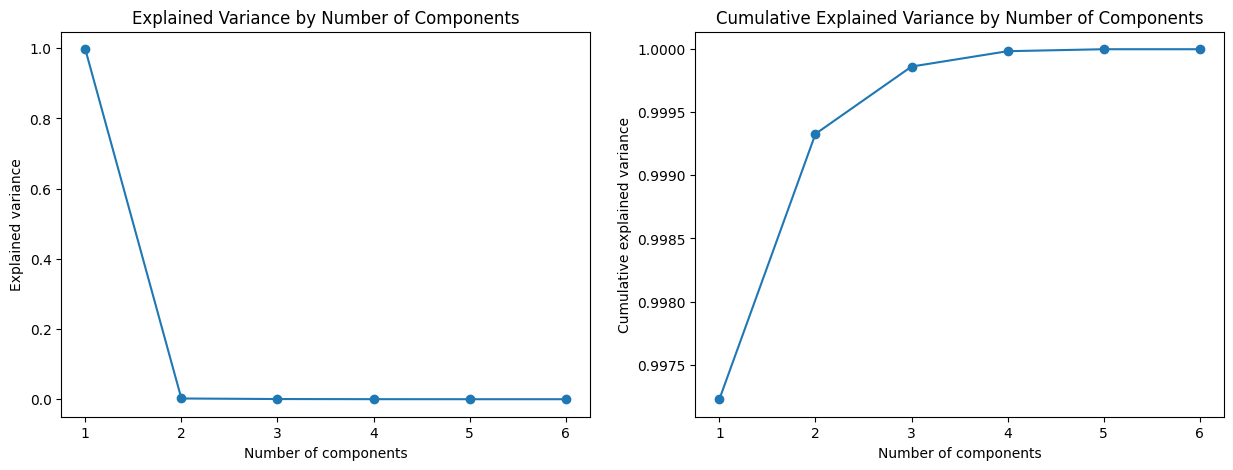

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# plot explained variance
ax[0].plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_ratio_, marker='o')
ax[0].set_xlabel('Number of components')
ax[0].set_ylabel('Explained variance')
ax[0].set_title('Explained Variance by Number of Components')

# plot cumulative explained variance
ax[1].plot(range(1, len(pca.explained_variance_)+1), np.cumsum(pca.explained_variance_ratio_), marker='o')
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Cumulative explained variance')
ax[1].set_title('Cumulative Explained Variance by Number of Components')

plt.show()


In [ ]:
# Select the number of components that explain at least 80-90% of the variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_explained_variance >= 0.8) + 1
print(f'Number of components to explain 80% of variance: {n_components}')


Number of components to explain 80% of variance: 1


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA


# Get the loadings for each variable
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

print(loadings)

                       PC1       PC2       PC3       PC4       PC5       PC6
MDVP:Shimmer      0.093565 -0.260663  0.302795  0.047401  0.910697 -0.000146
MDVP:Shimmer(dB)  0.978215  0.156017 -0.136541  0.000638 -0.010482  0.000007
Shimmer:APQ3      0.049192 -0.289422  0.028680 -0.064478 -0.093921  0.948691
Shimmer:APQ5      0.058832 -0.100302  0.325830  0.918624 -0.190901  0.000035
MDVP:APQ          0.081736  0.245140  0.880508 -0.335156 -0.213545  0.000009
Shimmer:DDA       0.147576 -0.868213  0.085964 -0.193380 -0.282233 -0.316206


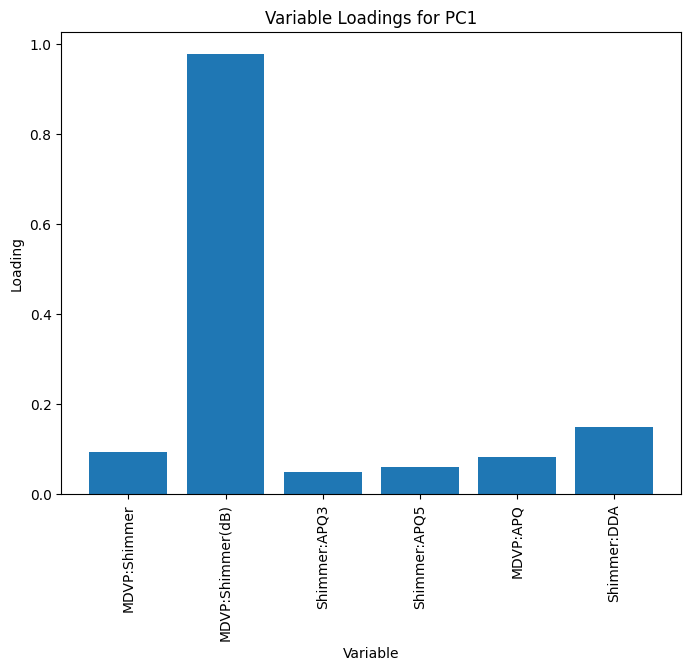

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Get the loadings for each variable
loadings = pd.DataFrame(pca.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Get the loadings for the first principal component
loadings_pc1 = loadings['PC1']

# Plot the variable loadings for the first principal component
plt.figure(figsize=(8, 6))
plt.bar(x=loadings_pc1.index, height=loadings_pc1.values)
plt.xticks(rotation=90)
plt.title('Variable Loadings for PC1')
plt.xlabel('Variable')
plt.ylabel('Loading')
plt.show()


**MDVP: Shimmer(db) for final modeling**

#Final Modelling

In [ ]:
df.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [ ]:
#Final Confusion Matrix

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr



variables = [ 'MDVP:Fhi(Hz)', 'Jitter:DDP',
      'MDVP:Shimmer(dB)',  'NHR', 'HNR',  'RPDE', 'DFA',
       'spread1', 'status']


selected_data = df[variables]


corr_matrix = selected_data.corr()


p_values = np.zeros_like(corr_matrix)
for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        corr, p_val = pearsonr(selected_data[variables[i]], selected_data[variables[j]])
        p_values[i, j] = p_val

p_values[p_values == 0] = np.nan

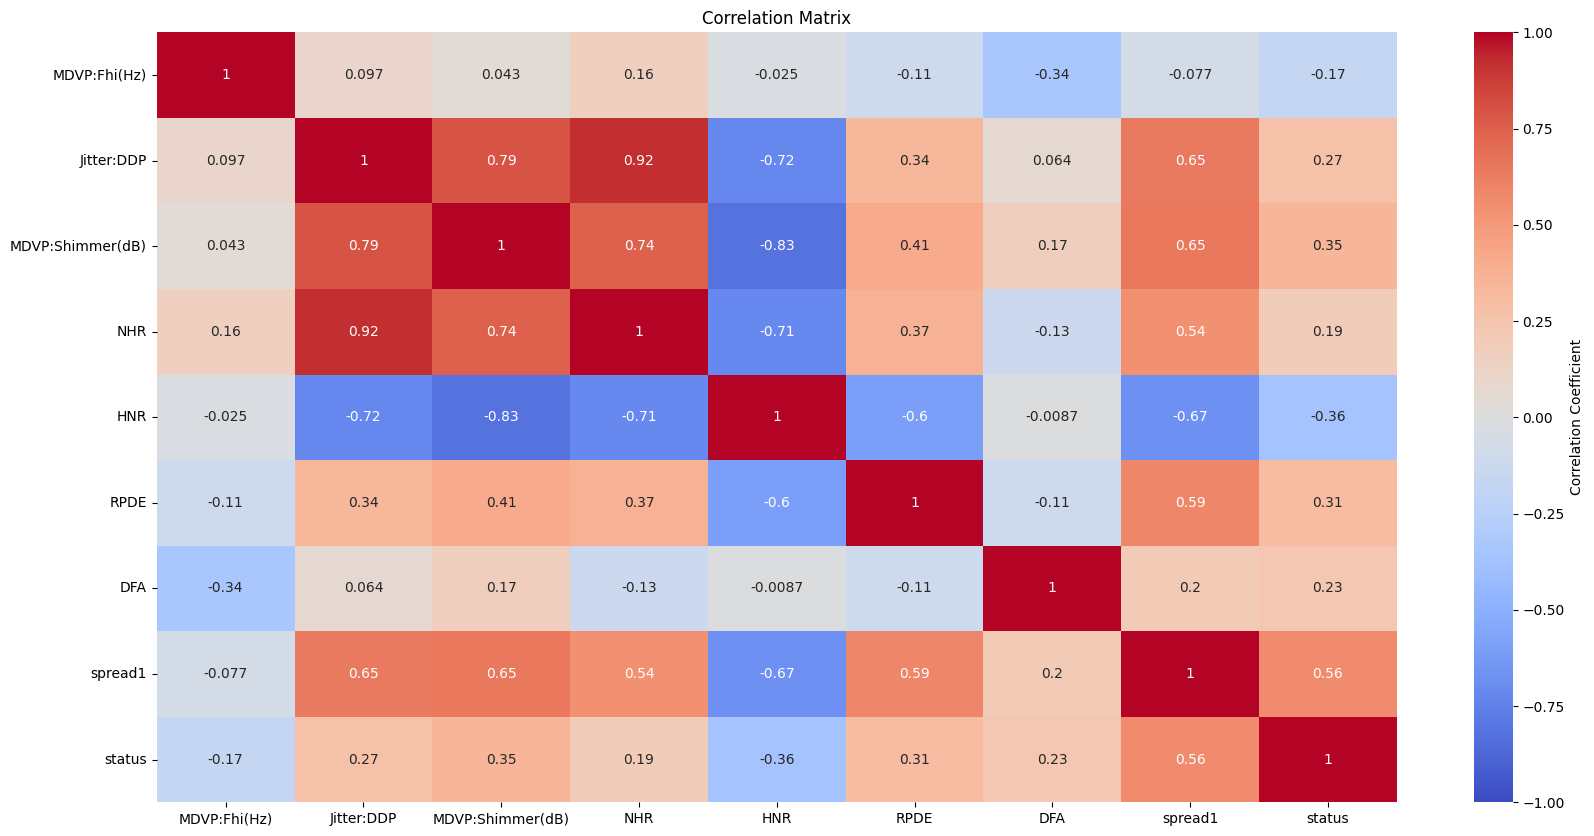

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix')
plt.show()


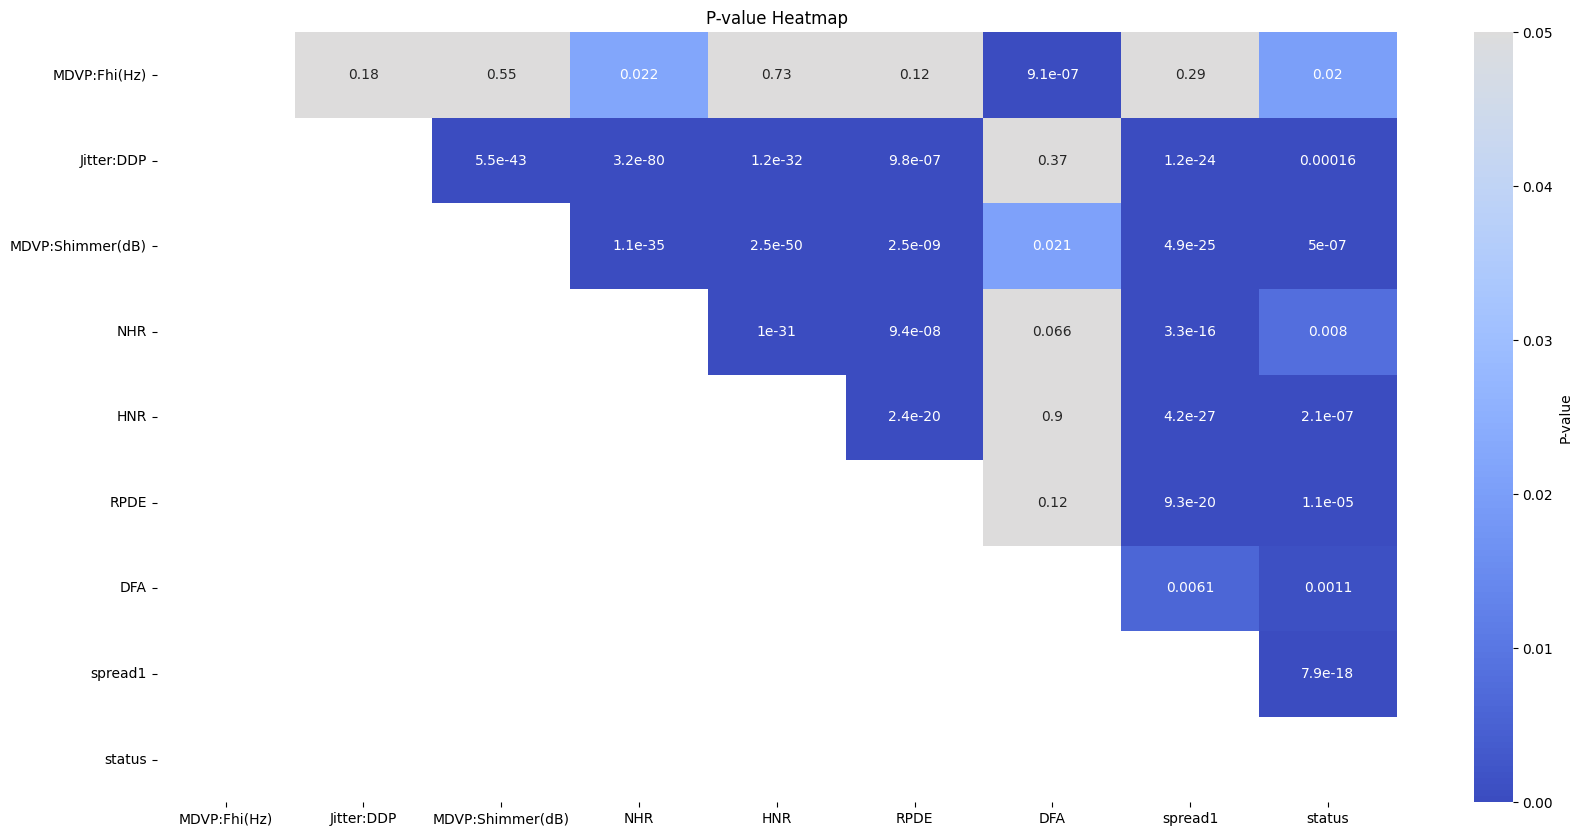

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(p_values, annot=True, cmap='coolwarm', vmin=0, vmax=0.05, center=0.05,
            xticklabels=variables, yticklabels=variables,
            cbar_kws={'label': 'P-value'})
plt.title('P-value Heatmap')
plt.show()

# Modeling using Jitter

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr



variables = [ 'MDVP:Fhi(Hz)', 'Jitter:DDP',   'RPDE', 'DFA', 'status']


selected_data = df[variables]


corr_matrix = selected_data.corr()


p_values = np.zeros_like(corr_matrix)
for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        corr, p_val = pearsonr(selected_data[variables[i]], selected_data[variables[j]])
        p_values[i, j] = p_val

p_values[p_values == 0] = np.nan

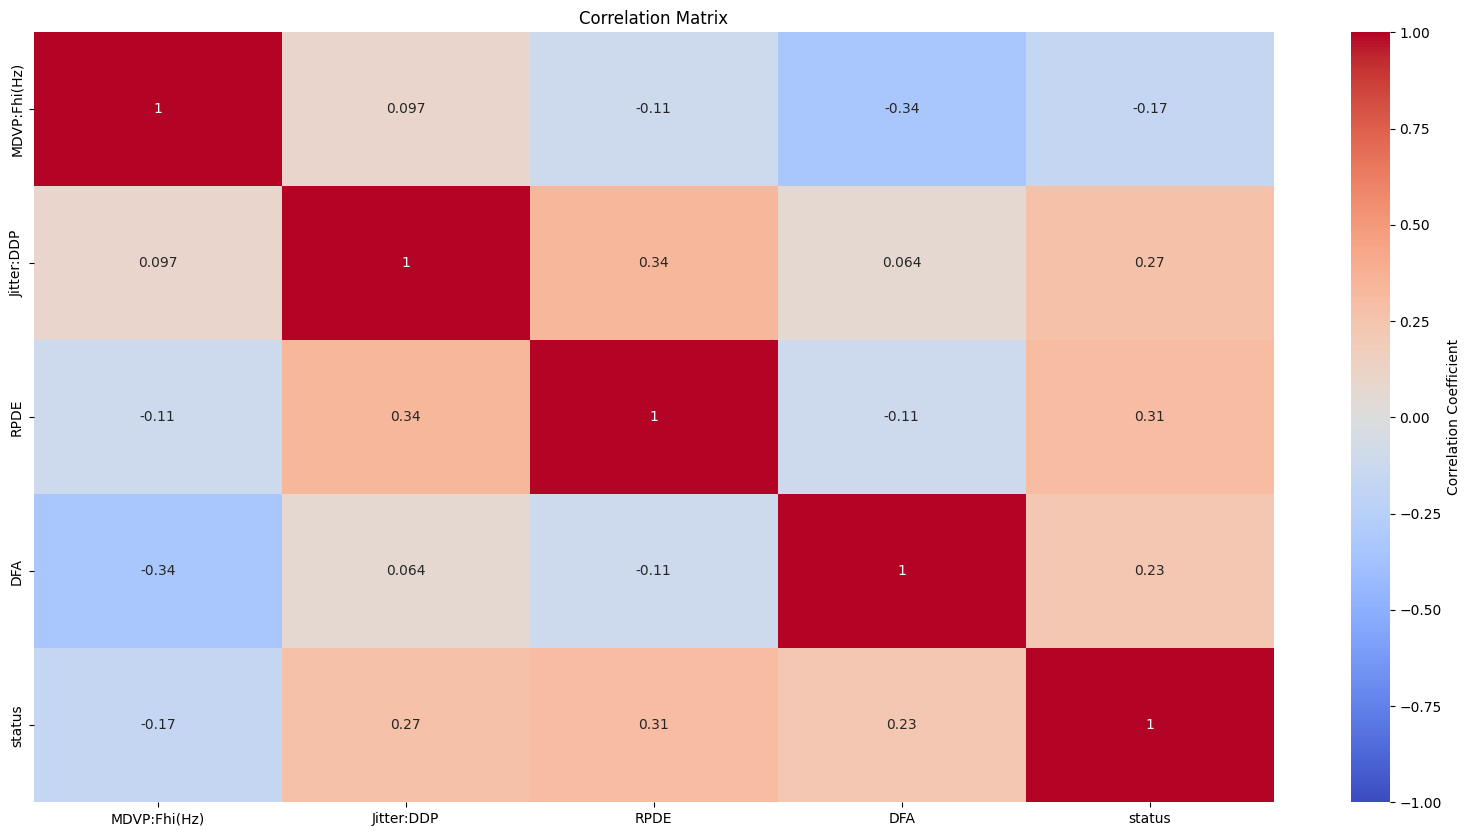

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix')
plt.show()


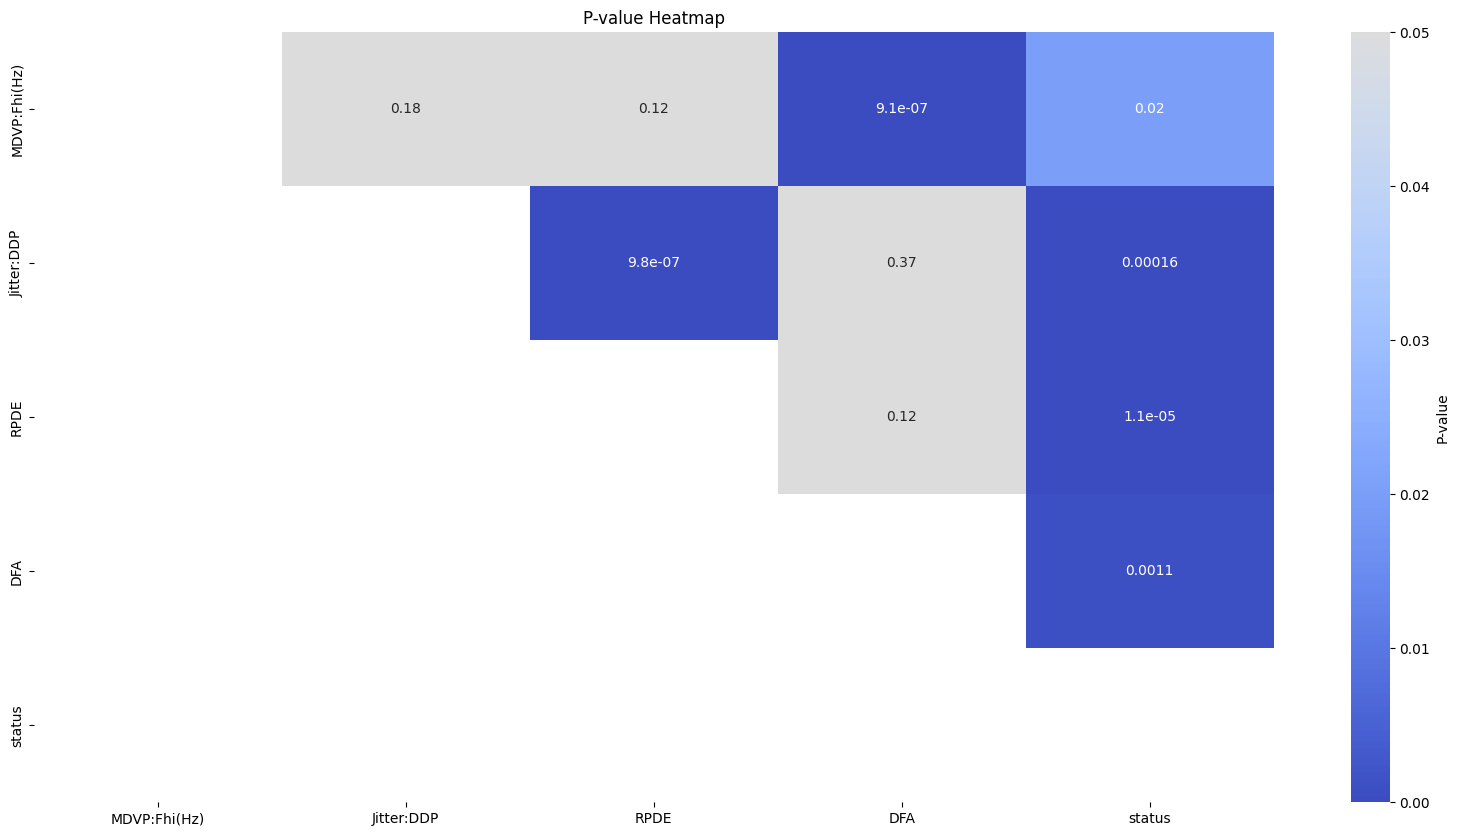

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(p_values, annot=True, cmap='coolwarm', vmin=0, vmax=0.05, center=0.05,
            xticklabels=variables, yticklabels=variables,
            cbar_kws={'label': 'P-value'})
plt.title('P-value Heatmap')
plt.show()

In [ ]:
X = df[['MDVP:Fhi(Hz)', 'Jitter:DDP',   'RPDE', 'DFA']]

y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier


# Initialize the Random Forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rfc.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rfc.predict(X_test)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Get the precision score
precision = precision_score(y_test, y_pred)

# Get the recall score
recall = recall_score(y_test, y_pred)

# Get the F1 score
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Confusion Matrix:
 [[11  4]
 [ 5 39]]
Accuracy: 0.847457627118644
Precision: 0.9069767441860465
Recall: 0.8863636363636364
F1 Score: 0.896551724137931


AUC- 80.98


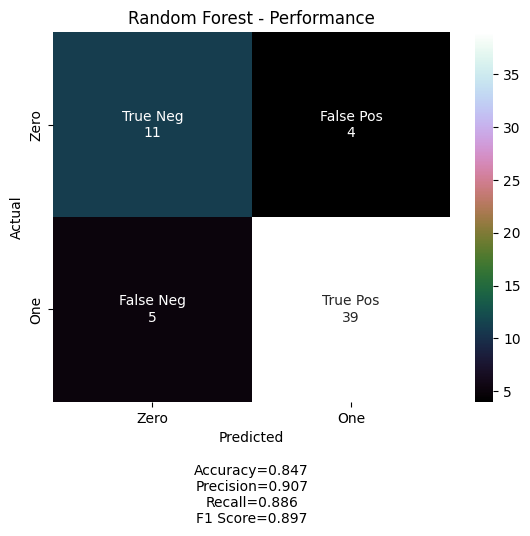

In [ ]:
# Plot Confusion Matrix
model_name = 'Random Forest'
cm = confusion_matrix(y_test, y_pred)
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, group_names=labels, categories=categories, percent=False, cmap='cubehelix')
plt.title(f'{model_name} - Performance')
print(f"AUC- {metrics.roc_auc_score(y_test, y_pred) *100:.2f}")

In [ ]:
importances = rfc.feature_importances_

# Get the indices of the most important features
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))


Feature ranking:
1. Jitter:DDP (0.335768)
2. MDVP:Fhi(Hz) (0.329677)
3. DFA (0.170486)
4. RPDE (0.164068)


In [ ]:
import xgboost as xgb



# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier()

# Fit the model on the training data
xgb_clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xgb_clf.predict(X_test)

# Get the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Get the classification report
cr = classification_report(y_test, y_pred)
print("Classification report:\n", cr)


Accuracy: 0.8135593220338984
Confusion matrix:
 [[ 9  6]
 [ 5 39]]
Classification report:
               precision    recall  f1-score   support

           0       0.64      0.60      0.62        15
           1       0.87      0.89      0.88        44

    accuracy                           0.81        59
   macro avg       0.75      0.74      0.75        59
weighted avg       0.81      0.81      0.81        59



AUC- 74.32


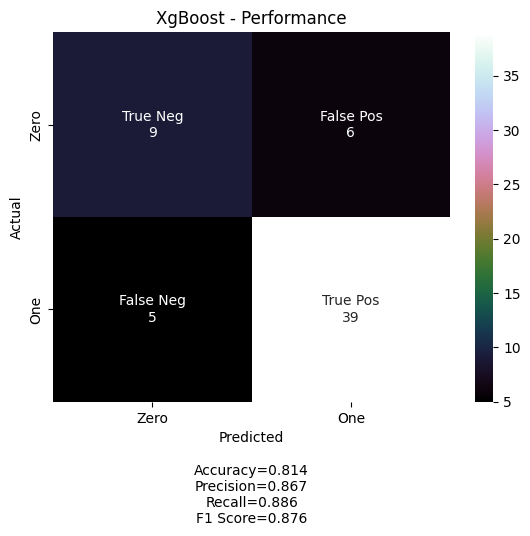

In [ ]:
# Plot Confusion Matrix
model_name = 'XgBoost'
cm = confusion_matrix(y_test, y_pred)
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, group_names=labels, categories=categories, percent=False, cmap='cubehelix')
plt.title(f'{model_name} - Performance')
print(f"AUC- {metrics.roc_auc_score(y_test, y_pred) *100:.2f}")

In [ ]:

# Get the feature importances
importances = xgb_clf.feature_importances_

# Print the feature importances
for i,v in enumerate(importances):
    print('Feature %d: %s, Score: %.5f' % (i+1,X_train.columns[i],v))


Feature 1: MDVP:Fhi(Hz), Score: 0.33310
Feature 2: Jitter:DDP, Score: 0.37338
Feature 3: RPDE, Score: 0.15142
Feature 4: DFA, Score: 0.14211


# Modelling using Shimmer

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr



variables = [ 'MDVP:Fhi(Hz)', 'MDVP:Shimmer(dB)',   'RPDE', 'DFA', 'status']


selected_data = df[variables]


corr_matrix = selected_data.corr()


p_values = np.zeros_like(corr_matrix)
for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        corr, p_val = pearsonr(selected_data[variables[i]], selected_data[variables[j]])
        p_values[i, j] = p_val

p_values[p_values == 0] = np.nan

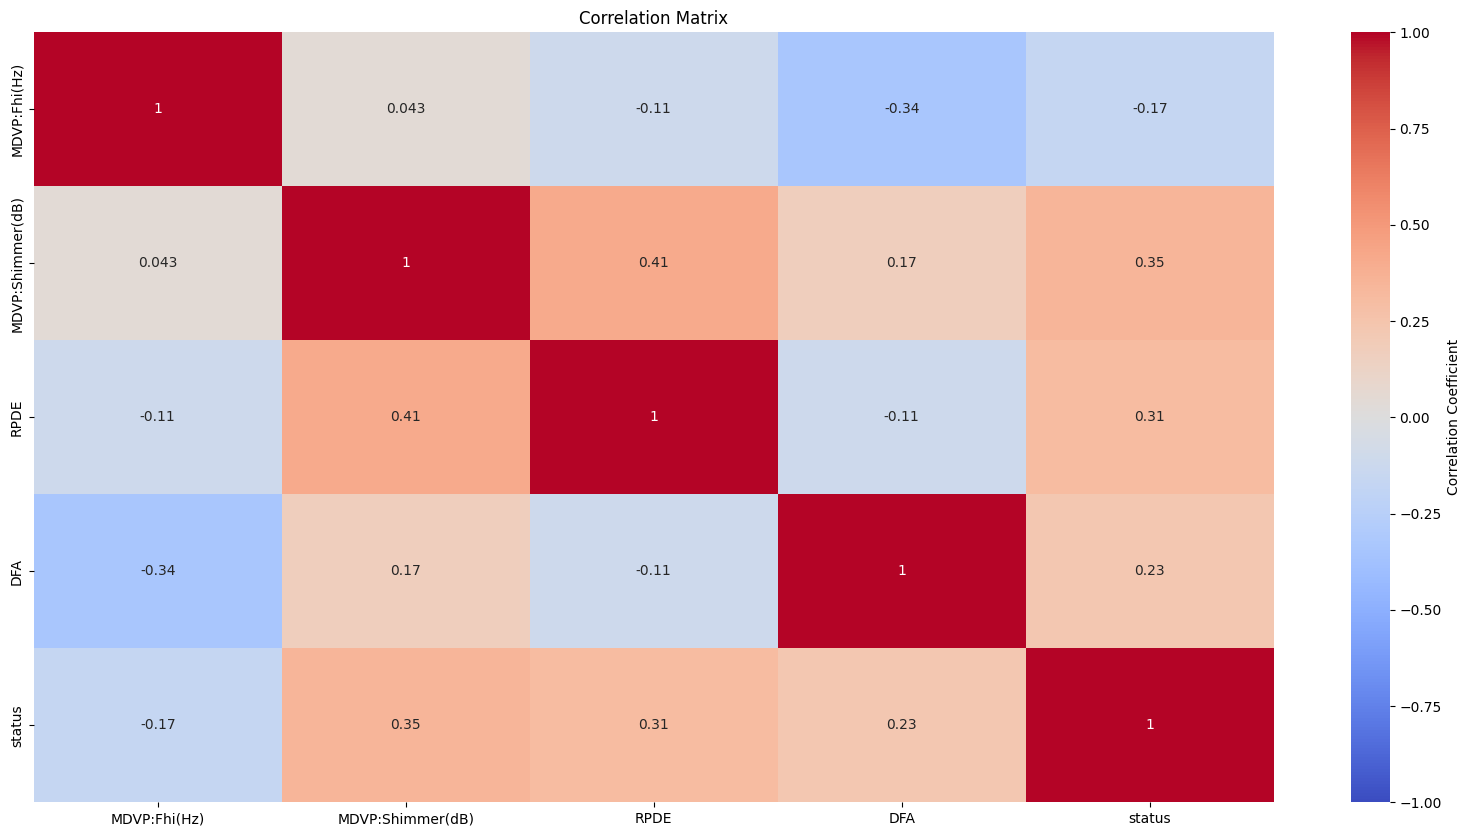

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix')
plt.show()


In [ ]:
df.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [ ]:
X = df[['MDVP:Fhi(Hz)', 'MDVP:Shimmer(dB)',  'DFA']]

y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier


# Initialize the Random Forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rfc.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rfc.predict(X_test)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Get the precision score
precision = precision_score(y_test, y_pred)

# Get the recall score
recall = recall_score(y_test, y_pred)

# Get the F1 score
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Confusion Matrix:
 [[10  5]
 [ 6 38]]
Accuracy: 0.8135593220338984
Precision: 0.8837209302325582
Recall: 0.8636363636363636
F1 Score: 0.8735632183908046


AUC- 76.52


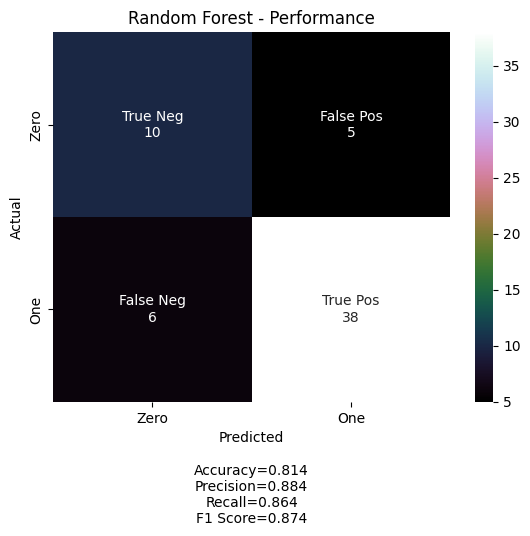

In [ ]:
# Plot Confusion Matrix
model_name = 'Random Forest'
cm = confusion_matrix(y_test, y_pred)
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, group_names=labels, categories=categories, percent=False, cmap='cubehelix')
plt.title(f'{model_name} - Performance')
print(f"AUC- {metrics.roc_auc_score(y_test, y_pred) *100:.2f}")

In [ ]:
importances = rfc.feature_importances_

# Get the indices of the most important features
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))


Feature ranking:
1. MDVP:Fhi(Hz) (0.373838)
2. MDVP:Shimmer(dB) (0.341505)
3. DFA (0.284657)


In [ ]:
import xgboost as xgb



# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier()

# Fit the model on the training data
xgb_clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xgb_clf.predict(X_test)

# Get the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Get the classification report
cr = classification_report(y_test, y_pred)
print("Classification report:\n", cr)


Accuracy: 0.8135593220338984
Confusion matrix:
 [[11  4]
 [ 7 37]]
Classification report:
               precision    recall  f1-score   support

           0       0.61      0.73      0.67        15
           1       0.90      0.84      0.87        44

    accuracy                           0.81        59
   macro avg       0.76      0.79      0.77        59
weighted avg       0.83      0.81      0.82        59



AUC- 78.71


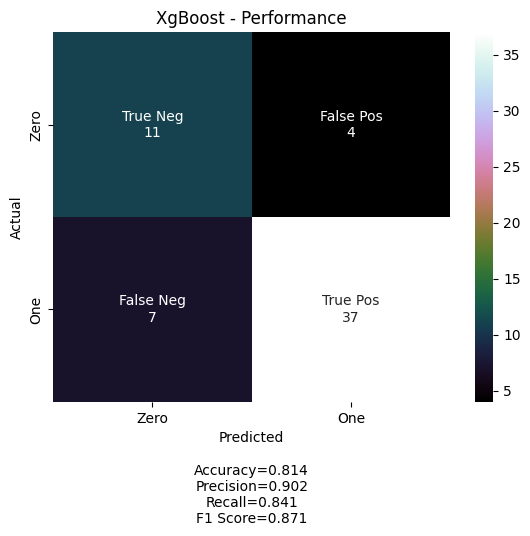

In [ ]:
# Plot Confusion Matrix
model_name = 'XgBoost'
cm = confusion_matrix(y_test, y_pred)
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, group_names=labels, categories=categories, percent=False, cmap='cubehelix')
plt.title(f'{model_name} - Performance')
print(f"AUC- {metrics.roc_auc_score(y_test, y_pred) *100:.2f}")

In [ ]:

# Get the feature importances
importances = xgb_clf.feature_importances_

# Print the feature importances
for i,v in enumerate(importances):
    print('Feature %d: %s, Score: %.5f' % (i+1,X_train.columns[i],v))


Feature 1: MDVP:Fhi(Hz), Score: 0.44190
Feature 2: MDVP:Shimmer(dB), Score: 0.35413
Feature 3: DFA, Score: 0.20397
